### 데이터 및 실험 구성

In [1]:
# 라이브러리
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 사이킷런 등
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.formula.api as smf

In [3]:
# 평가함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)    # 오차행렬
    accuracy = accuracy_score(y_test , pred)      # 정확도
    precision = precision_score(y_test , pred)    # 정밀도
    recall = recall_score(y_test , pred)          # 재현율
    f1 = f1_score(y_test,pred)
                    
    print('오차 행렬')
    print(confusion)
    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, F1: {:.4f}'
          .format(accuracy, precision, recall, f1))

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data['TAG'] = data['TAG'].apply(lambda x : 0 if x =='OK' else 1 )

split_date = int(len(data) * 0.7)
train = data[:split_date]
test = data[split_date:]
train.shape, test.shape

((584640, 7), (250560, 7))

### 전체 데이터 EDA

#### static

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 44.6+ MB


In [12]:
data.isna().sum()

STD_DT         0
NUM            0
MELT_TEMP      0
MOTORSPEED     0
MELT_WEIGHT    0
INSP           0
TAG            0
dtype: int64

In [13]:
data.describe(include='all')

STD_DT            NUM      MELT_TEMP     MOTORSPEED  \
count            835200  835200.000000  835200.000000  835200.000000   
unique            83520            NaN            NaN            NaN   
top     2020-03-04 0:00            NaN            NaN            NaN   
freq                 10            NaN            NaN            NaN   
mean                NaN  417599.500000     509.200623     459.782865   
std                 NaN  241101.616751     128.277519     639.436413   
min                 NaN       0.000000     308.000000       0.000000   
25%                 NaN  208799.750000     430.000000     119.000000   
50%                 NaN  417599.500000     469.000000     168.000000   
75%                 NaN  626399.250000     502.000000     218.000000   
max                 NaN  835199.000000     832.000000    1804.000000   

          MELT_WEIGHT           INSP            TAG  
count   835200.000000  835200.000000  835200.000000  
unique            NaN            NaN            NaN  
top               NaN            NaN            NaN  
freq              NaN            NaN            NaN  
mean       582.962125       3.194853       0.212006  
std       1217.604433       0.011822       0.408729  
min          0.000000       3.170000       0.000000  
25%        186.000000       3.190000       0.000000  
50%        383.000000       3.190000       0.000000  
75%        583.000000       3.200000       0.000000  
max      55252.000000       3.230000       1.000000

In [14]:
# 타겟분포
data['TAG'].value_counts(normalize='True')

0    0.787994
1    0.212006
Name: TAG, dtype: float64

<AxesSubplot:xlabel='TAG'>

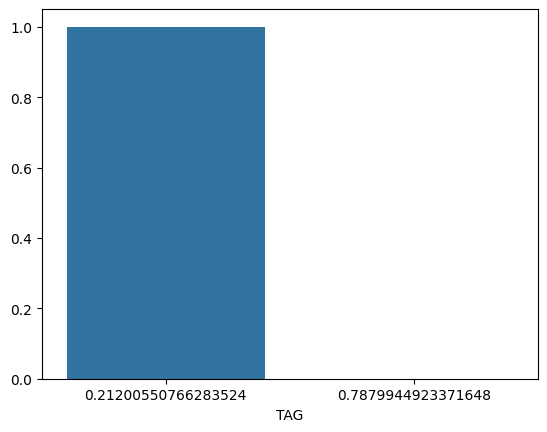

In [16]:
sns.barplot(x=data['TAG'].value_counts(normalize='True').index ,y=data['TAG'].value_counts(normalize='True'))

In [16]:
data['TAG'].value_counts()

0    658133
1    177067
Name: TAG, dtype: int64

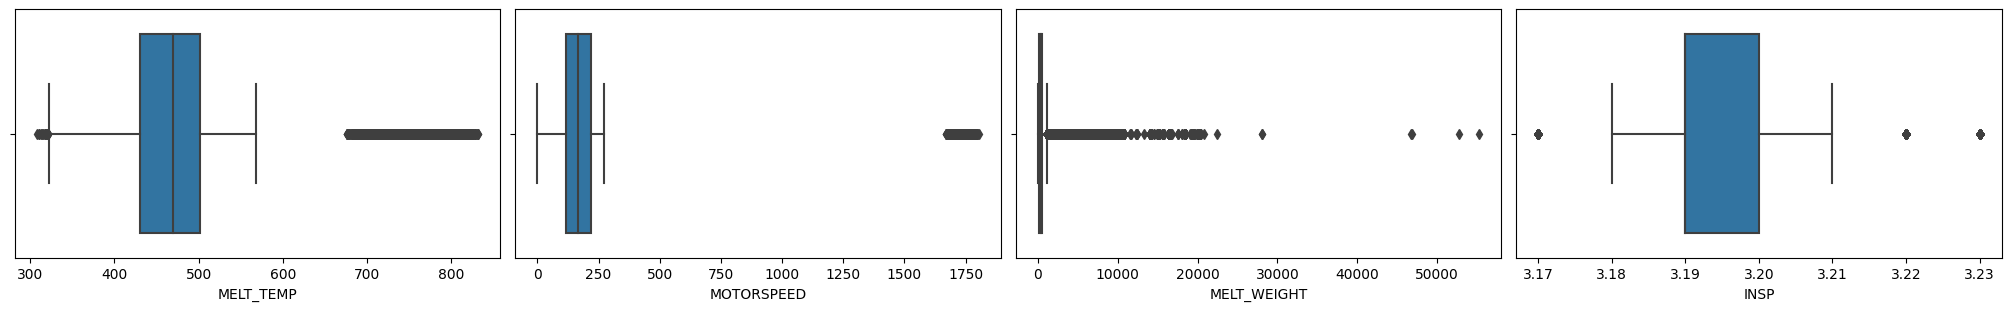

In [17]:
# 박스플롯
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.boxplot(data=data, x= col, ax = axs[idx])

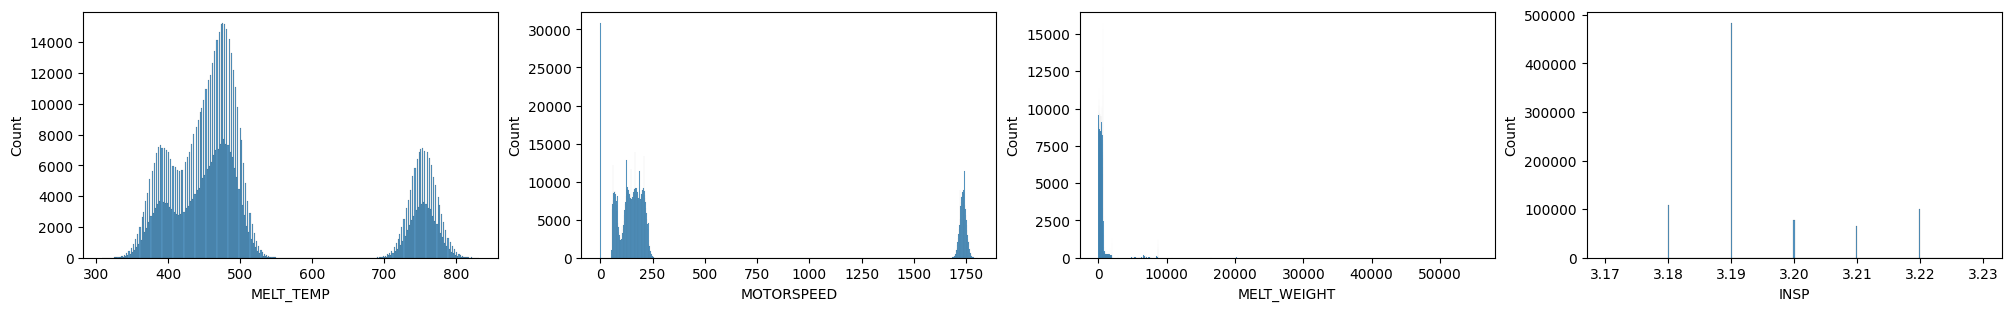

In [18]:
# 히스토그램
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.histplot(data=data, x= col, ax = axs[idx], bins='auto')

In [7]:
data[['MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP','TAG']].corr()

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP       TAG
MELT_TEMP     1.000000    0.944929    -0.000336  0.916295 -0.310586
MOTORSPEED    0.944929    1.000000     0.000123  0.887813 -0.264693
MELT_WEIGHT  -0.000336    0.000123     1.000000 -0.000005  0.012084
INSP          0.916295    0.887813    -0.000005  1.000000 -0.272580
TAG          -0.310586   -0.264693     0.012084 -0.272580  1.000000

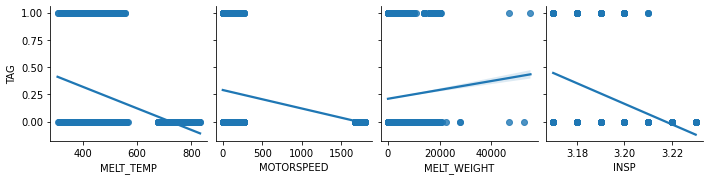

In [80]:
sns.pairplot(data=data, y_vars = 'TAG', x_vars = data.columns[2:-1], kind='reg')

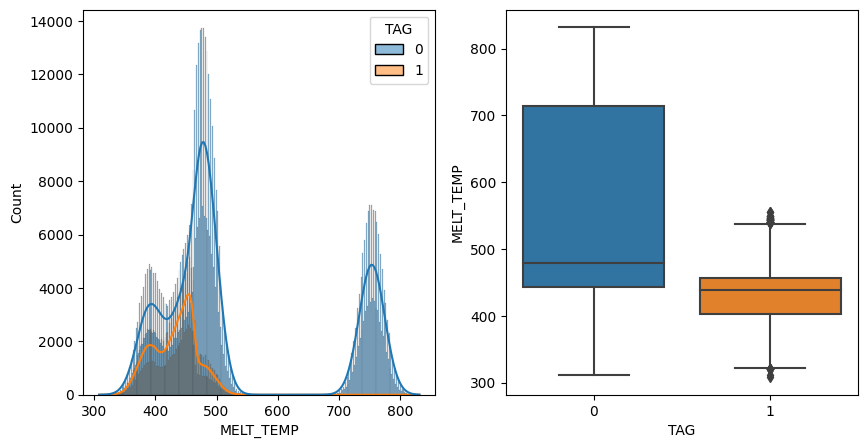

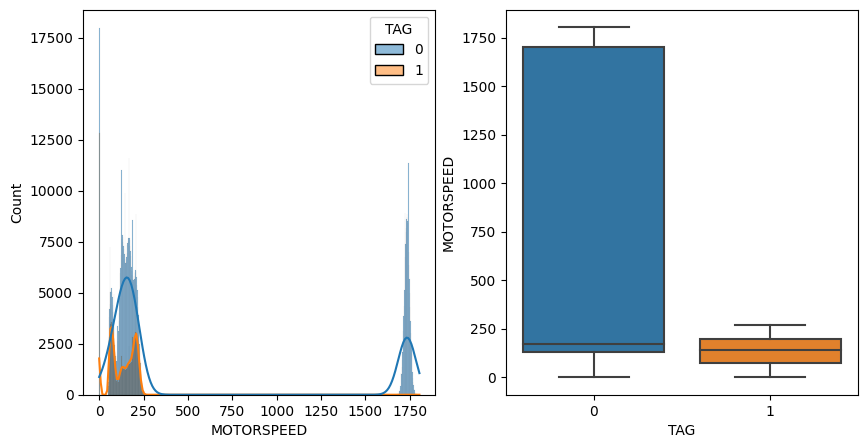

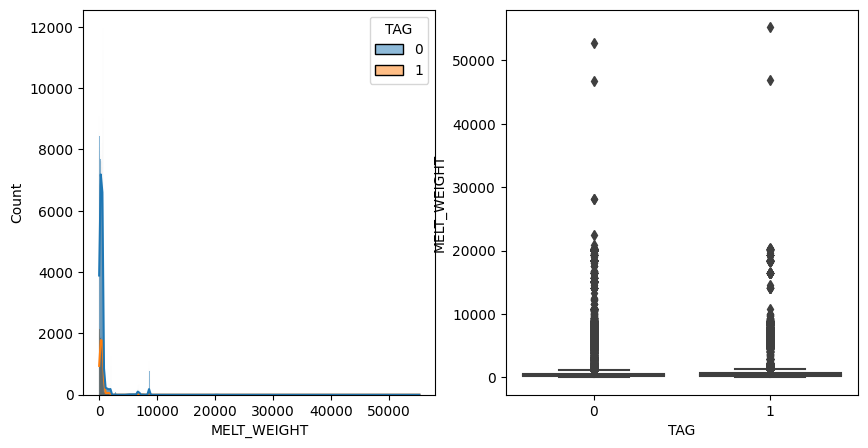

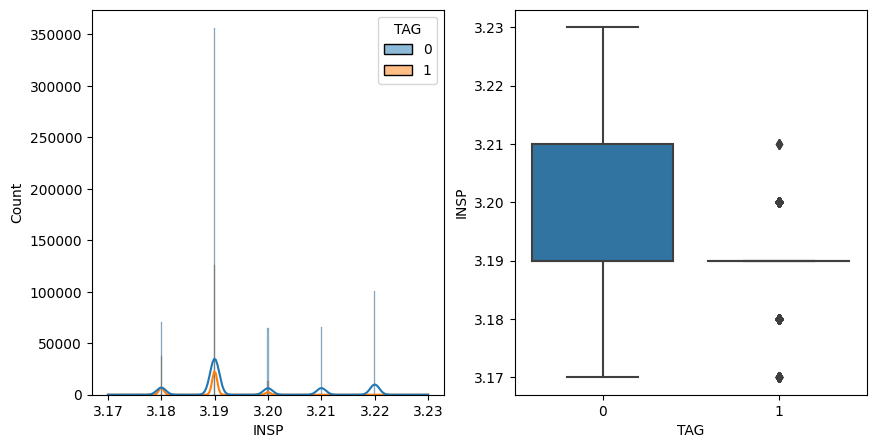

In [31]:
# TAG별 데이터 확인
for i in ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP'] :

    fig, axs = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

    sns.histplot(data= data, x=i, hue = 'TAG', kde=True, ax = axs[0])
    sns.boxplot(data= data, y=i, x='TAG', ax = axs[1])

#### dynamic

In [18]:
# 날짜형 수정
data['STD_DT'] = data['STD_DT'].apply(lambda x : pd.to_datetime(x))
data_dy = data.set_index('STD_DT')

In [19]:
data_dy.head(20)

# 6초에 데이터 생성 : 10번 > 1분

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP  TAG
STD_DT                                                                 
2020-03-04 00:00:00    0        489         116          631  3.19    0
2020-03-04 00:00:00    1        433          78          609  3.19    0
2020-03-04 00:00:00    2        464         154          608  3.19    0
2020-03-04 00:00:00    3        379         212          606  3.19    0
2020-03-04 00:00:00    4        798        1736          604  3.21    0
2020-03-04 00:00:00    5        743        1722          603  3.21    0
2020-03-04 00:00:00    6        390         212          602  3.19    0
2020-03-04 00:00:00    7        493         152          600  3.19    0
2020-03-04 00:00:00    8        427           0          599  3.19    0
2020-03-04 00:00:00    9        489         148          598  3.20    0
2020-03-04 00:01:00   10        507         128          596  3.19    0
2020-03-04 00:01:00   11        408          66          595  3.19    0
2020-03-04 00:01:00   12        474         138          594  3.19    0
2020-03-04 00:01:00   13        358         201          592  3.19    0
2020-03-04 00:01:00   14        740        1740          590  3.22    0
2020-03-04 00:01:00   15        772        1729          588  3.22    0
2020-03-04 00:01:00   16        424         195          586  3.18    0
2020-03-04 00:01:00   17        460         158          585  3.19    0
2020-03-04 00:01:00   18        440           0          584  3.19    0
2020-03-04 00:01:00   19        504         133          582  3.19    0

<AxesSubplot:xlabel='STD_DT'>

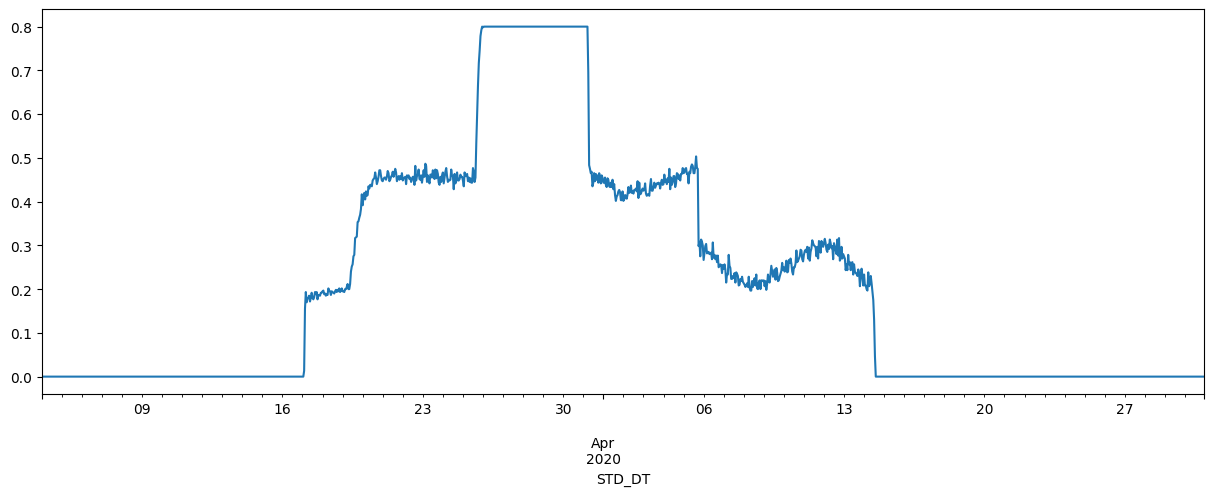

In [20]:
# 시각화 : TAG 시계열
data_dy.resample('H').mean()['TAG'].plot(figsize=(15,5))

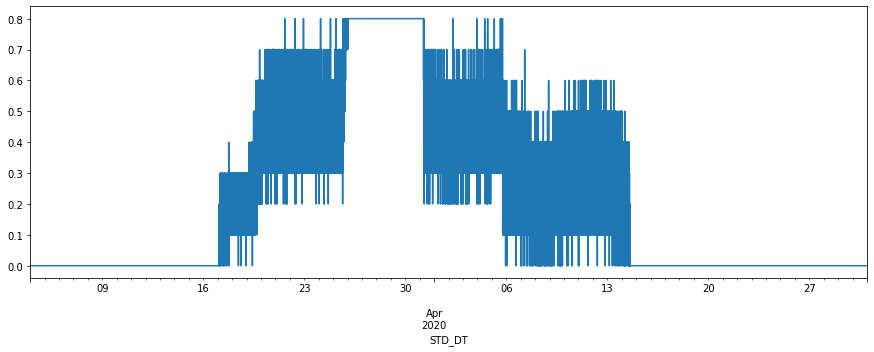

In [40]:
# 시각화 : TAG 시계열
data_dy.resample('T').mean()['TAG'].plot(figsize=(15,5))

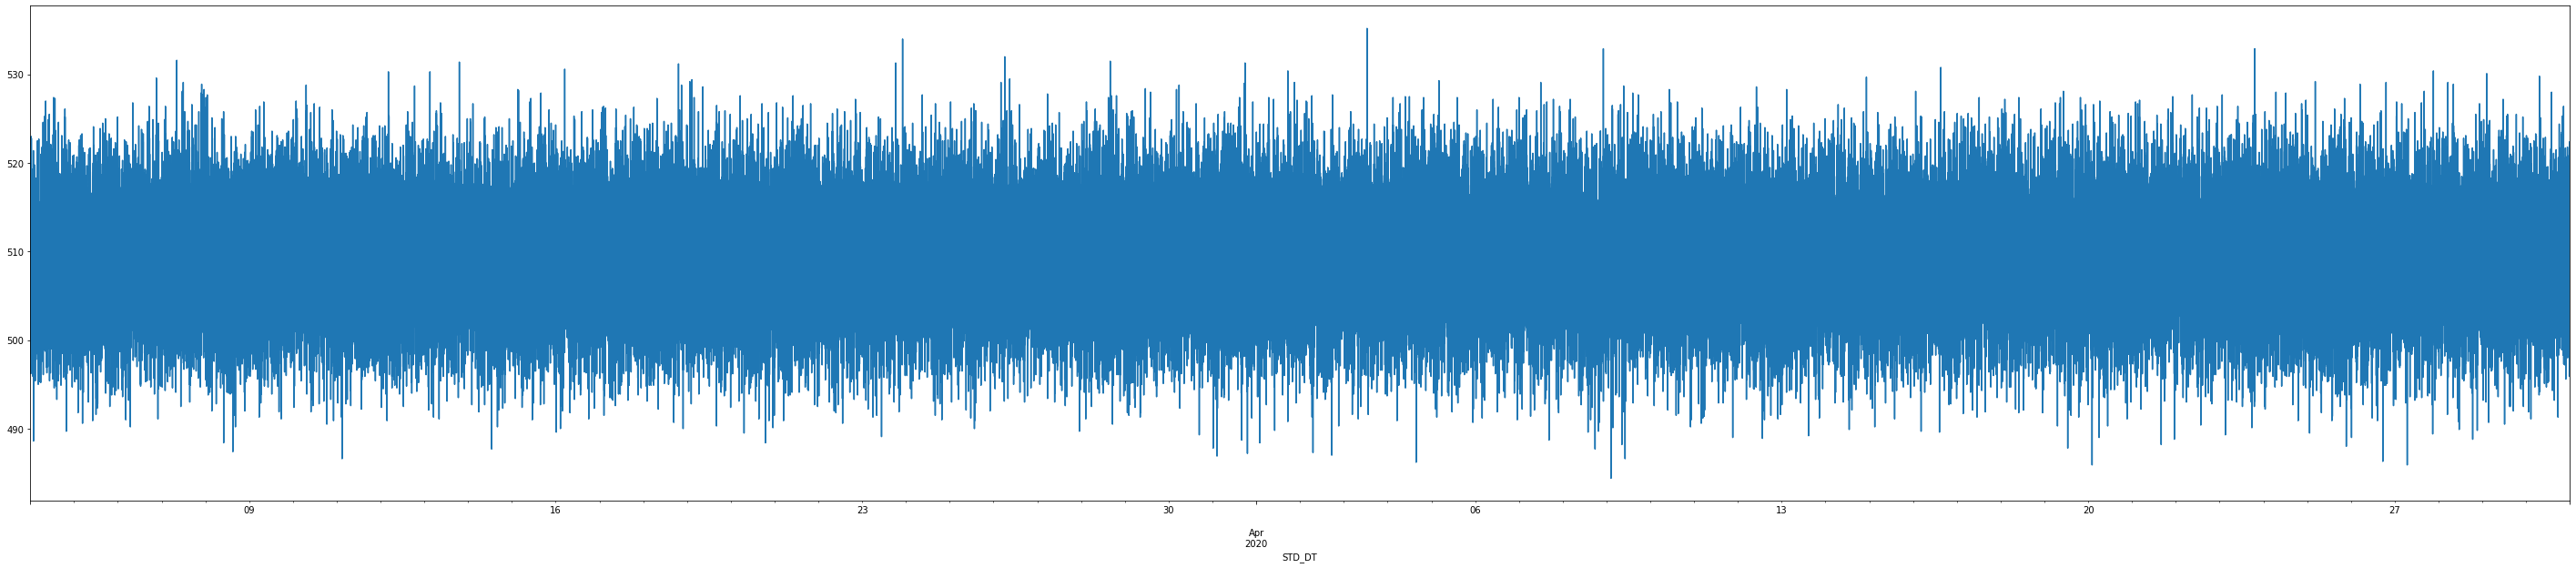

In [46]:
# 시각화 : MELT_TEMP
data_dy.resample('T').mean()['MELT_TEMP'].plot(figsize=(50,10))

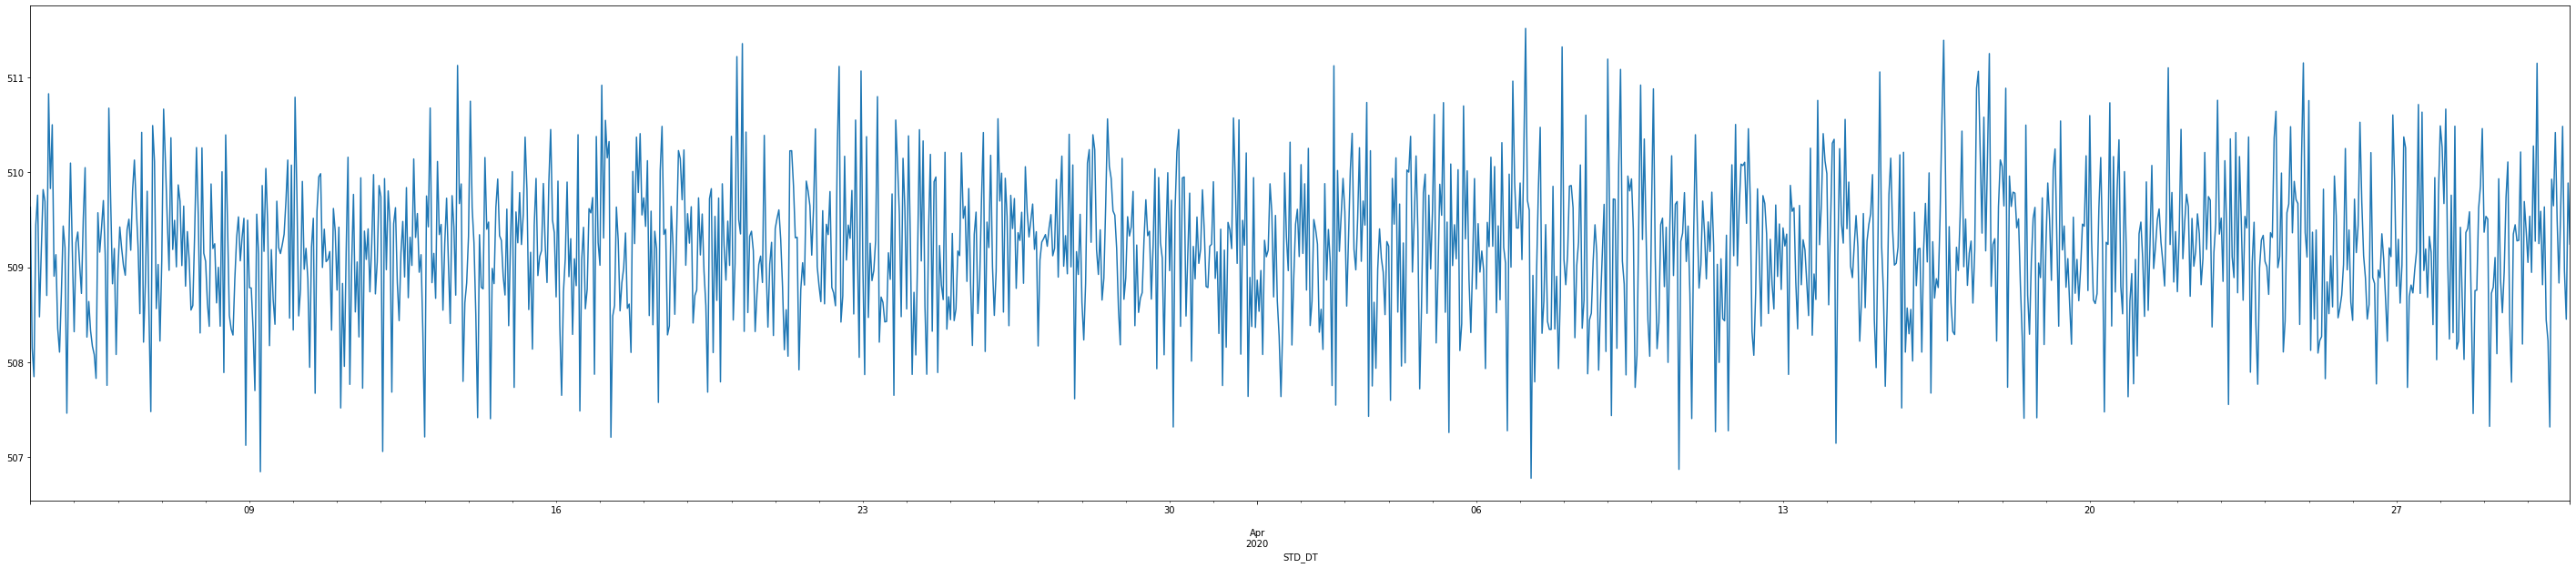

In [48]:
# 시각화 : MELT_TEMP
data_dy.resample('H').mean()['MELT_TEMP'].plot(figsize=(50,10))

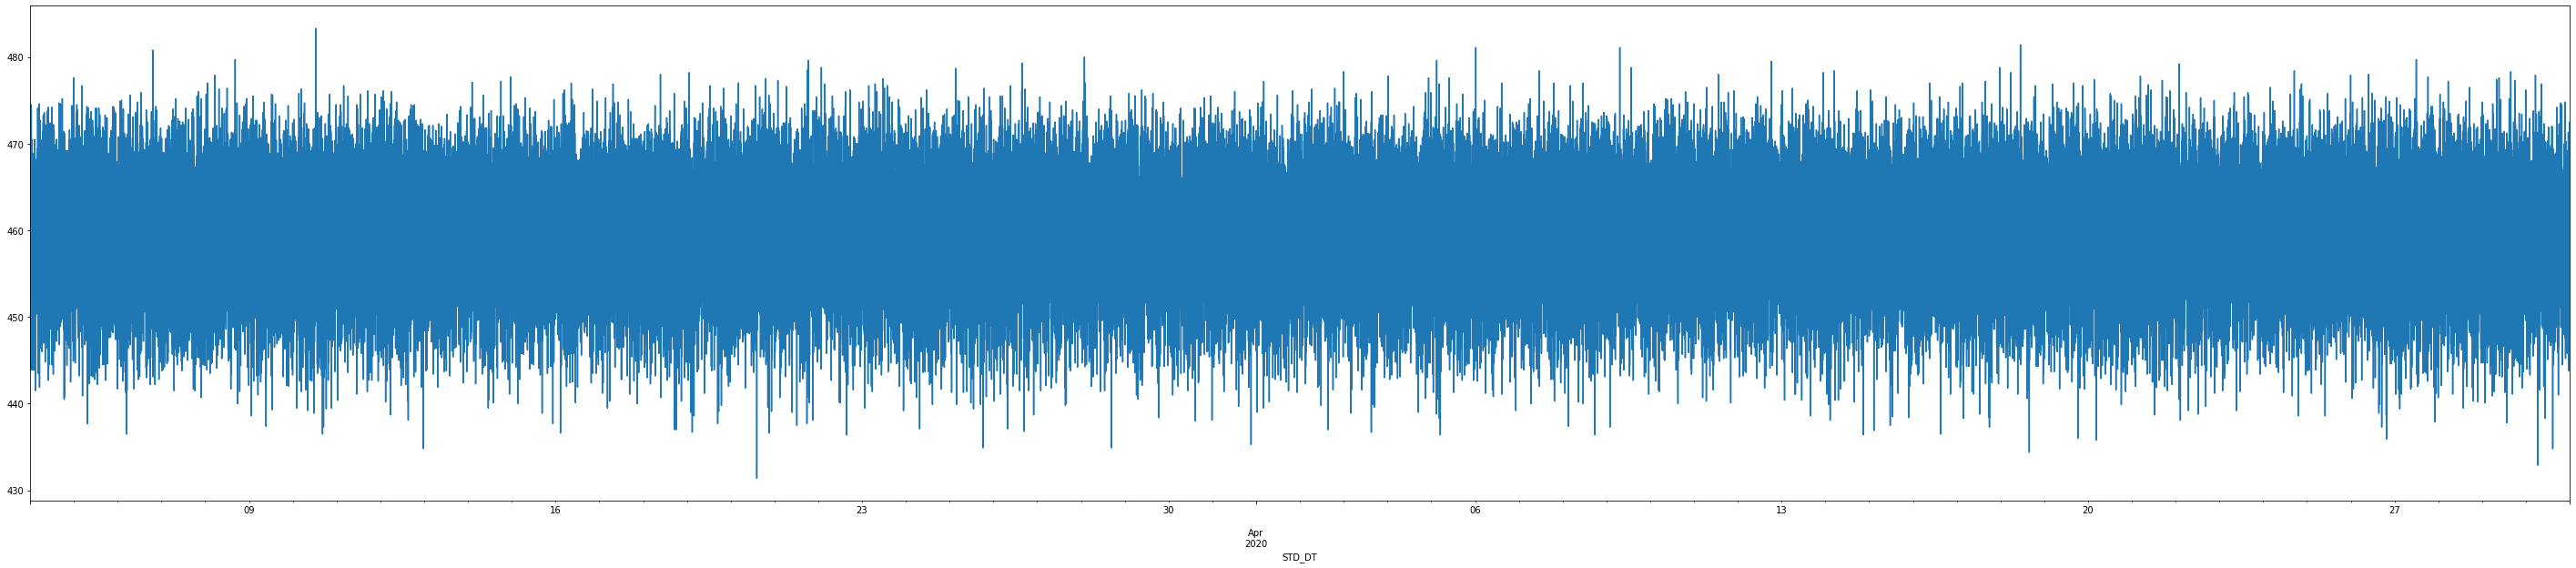

In [47]:
# 시각화 : MOTORSPEED
data_dy.resample('T').mean()['MOTORSPEED'].plot(figsize=(50,10))

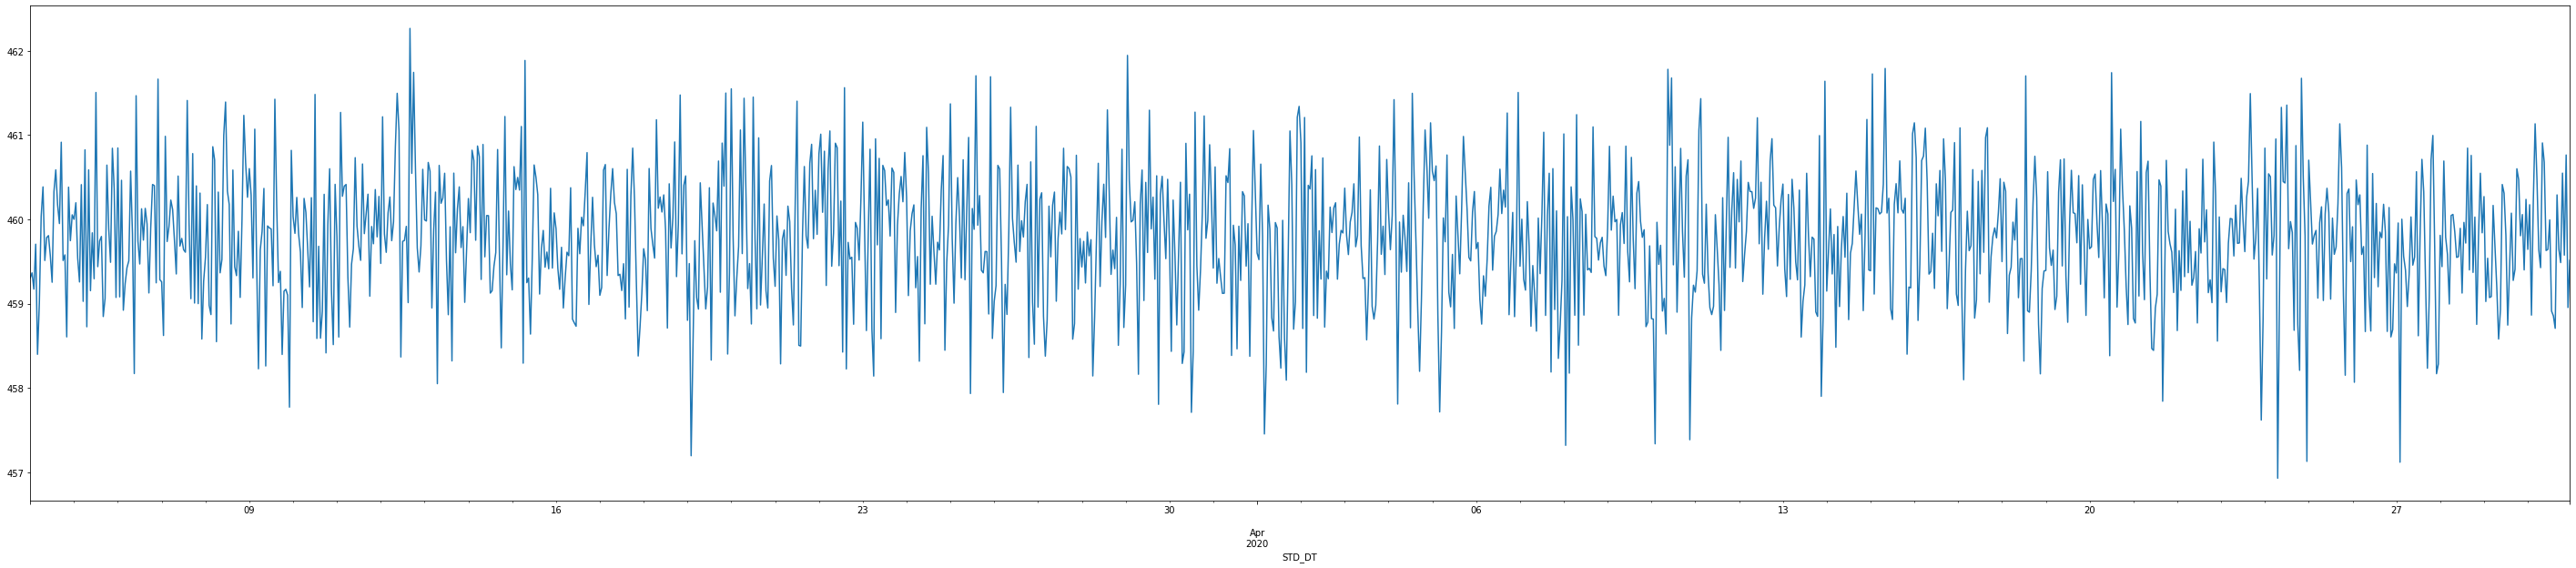

In [49]:
# 시각화 : MOTORSPEED
data_dy.resample('H').mean()['MOTORSPEED'].plot(figsize=(50,10))

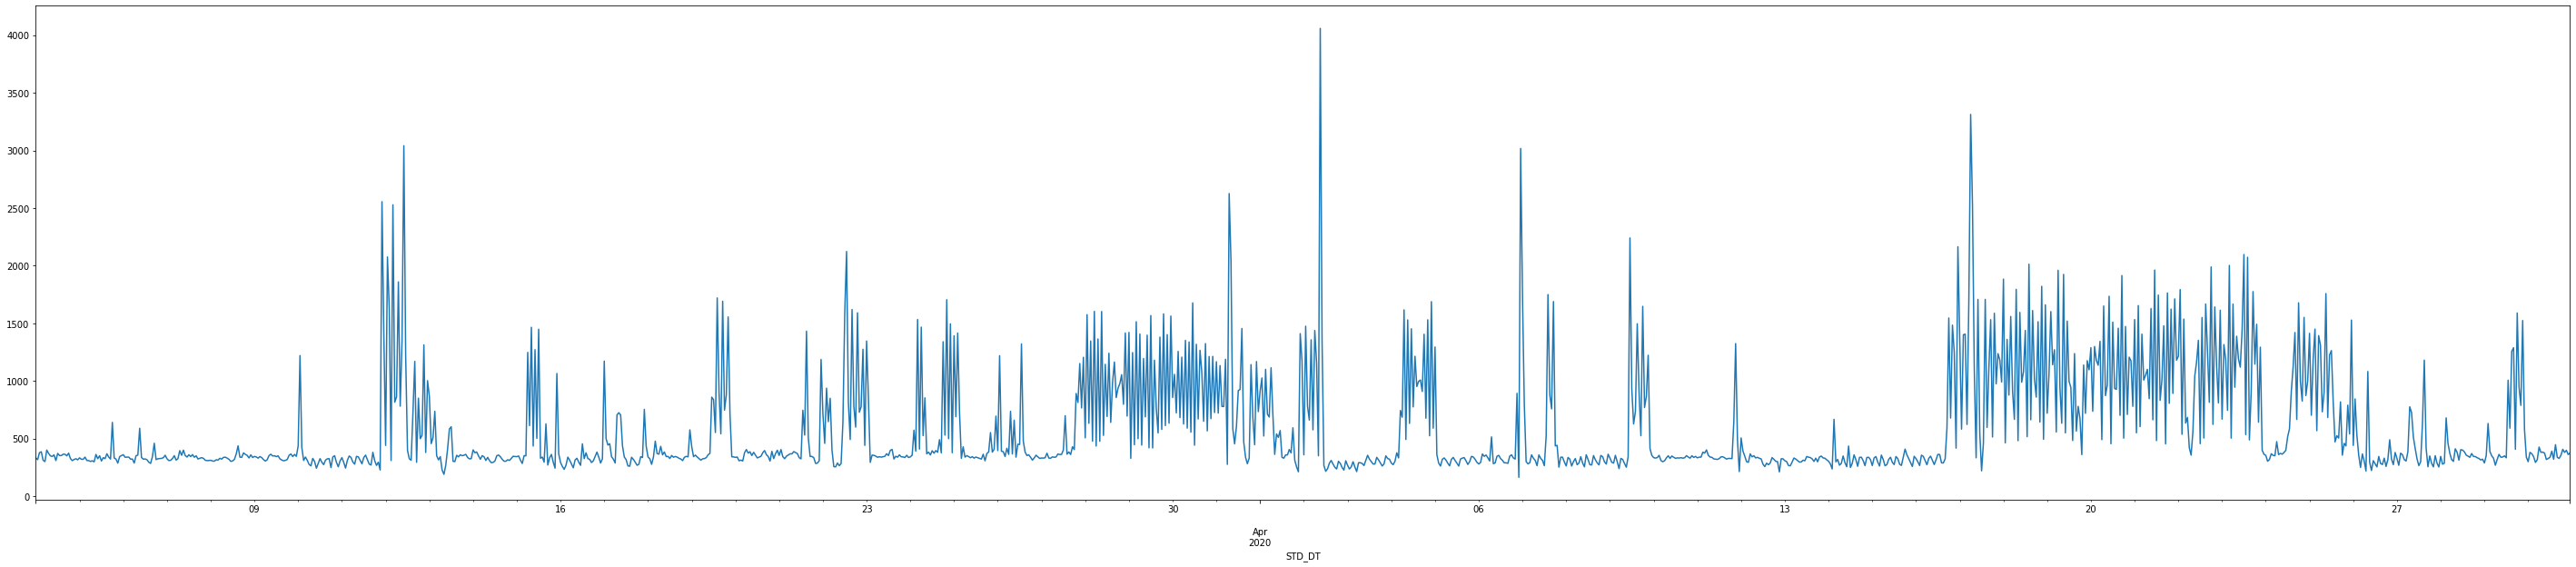

In [50]:
# 시각화 : MELT_WEIGHT
data_dy.resample('H').mean()['MELT_WEIGHT'].plot(figsize=(50,10))

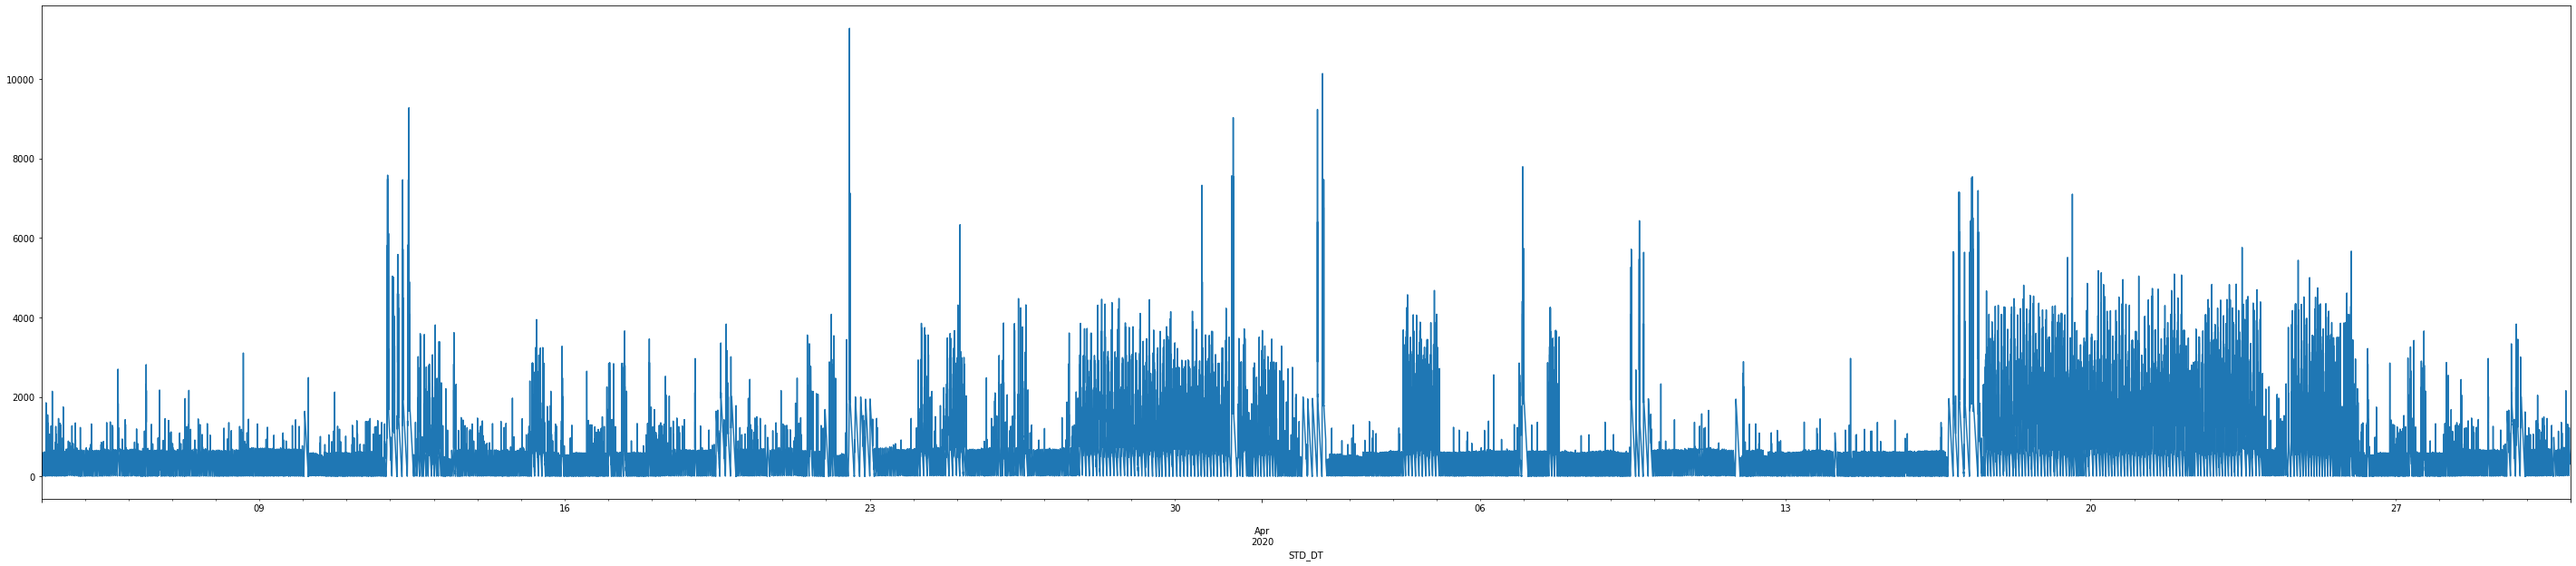

In [51]:
# 시각화 : MELT_WEIGHT
data_dy.resample('T').mean()['MELT_WEIGHT'].plot(figsize=(50,10))

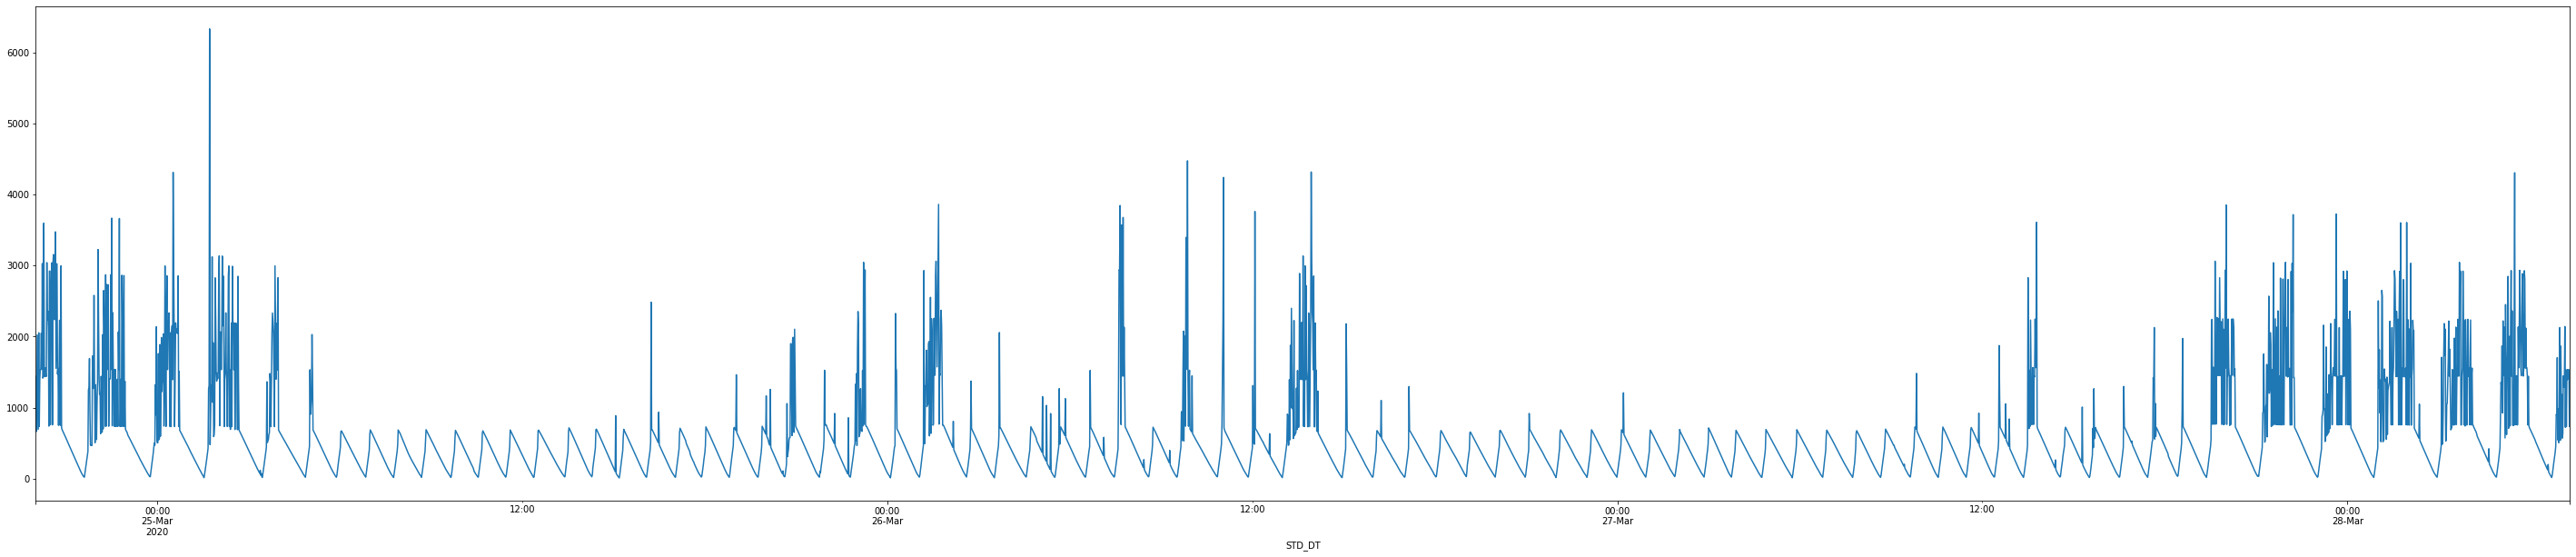

In [52]:
# 시각화 : MELT_WEIGHT 
data_dy.resample('T').mean()['MELT_WEIGHT'].iloc[30000:35000].plot(figsize=(50,10))

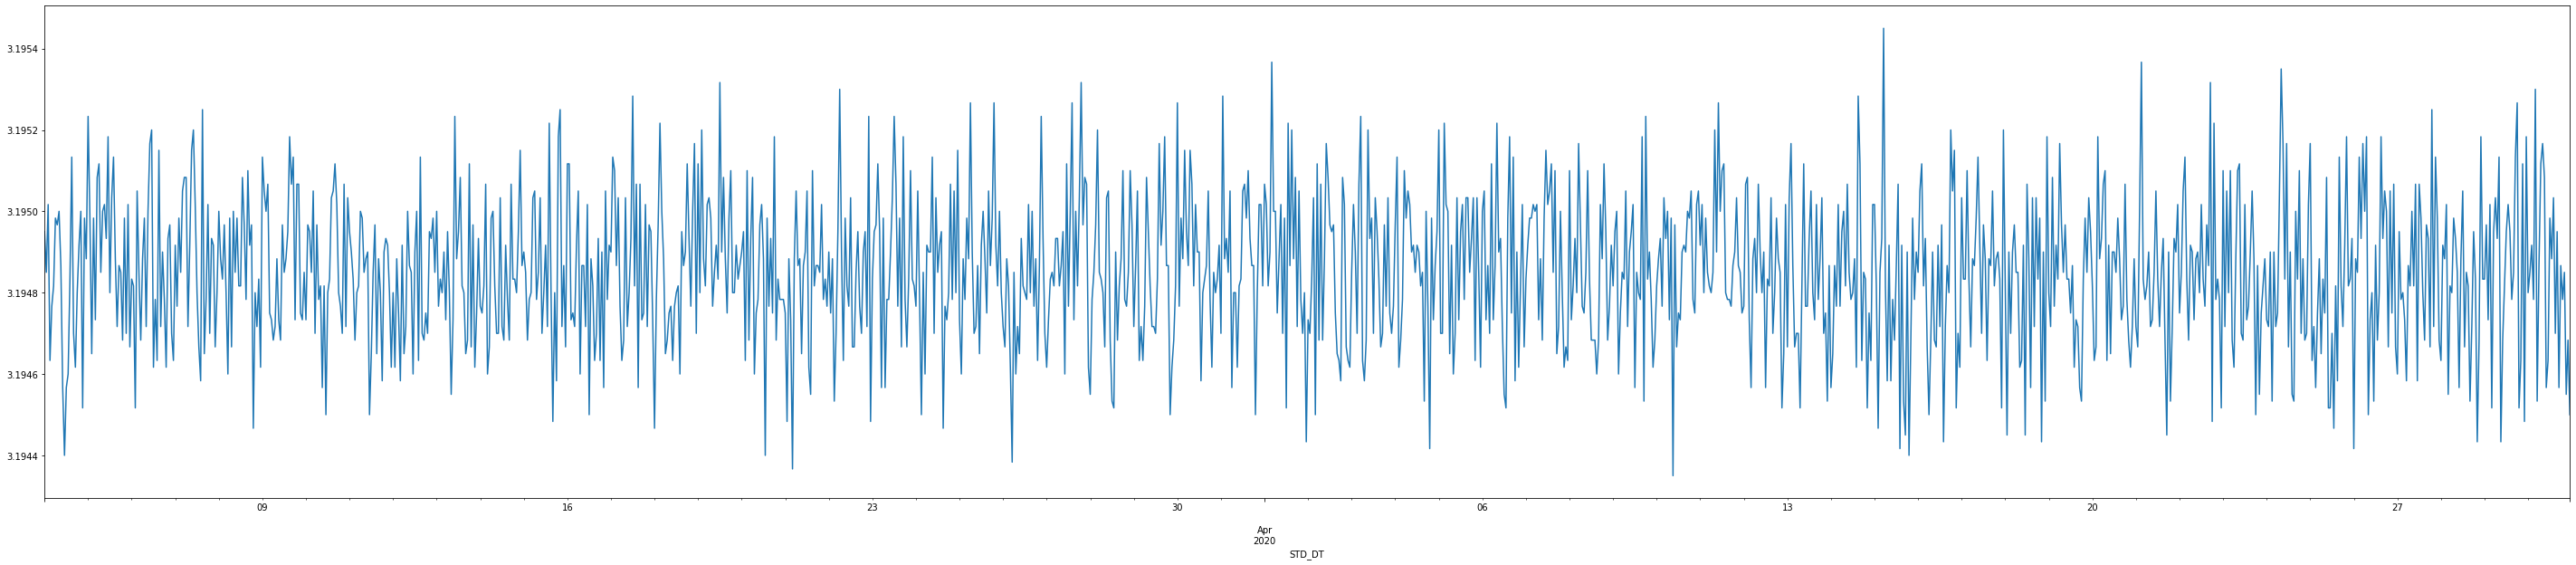

In [58]:
data_dy.resample('H').mean()['INSP'].plot(figsize=(50,10))

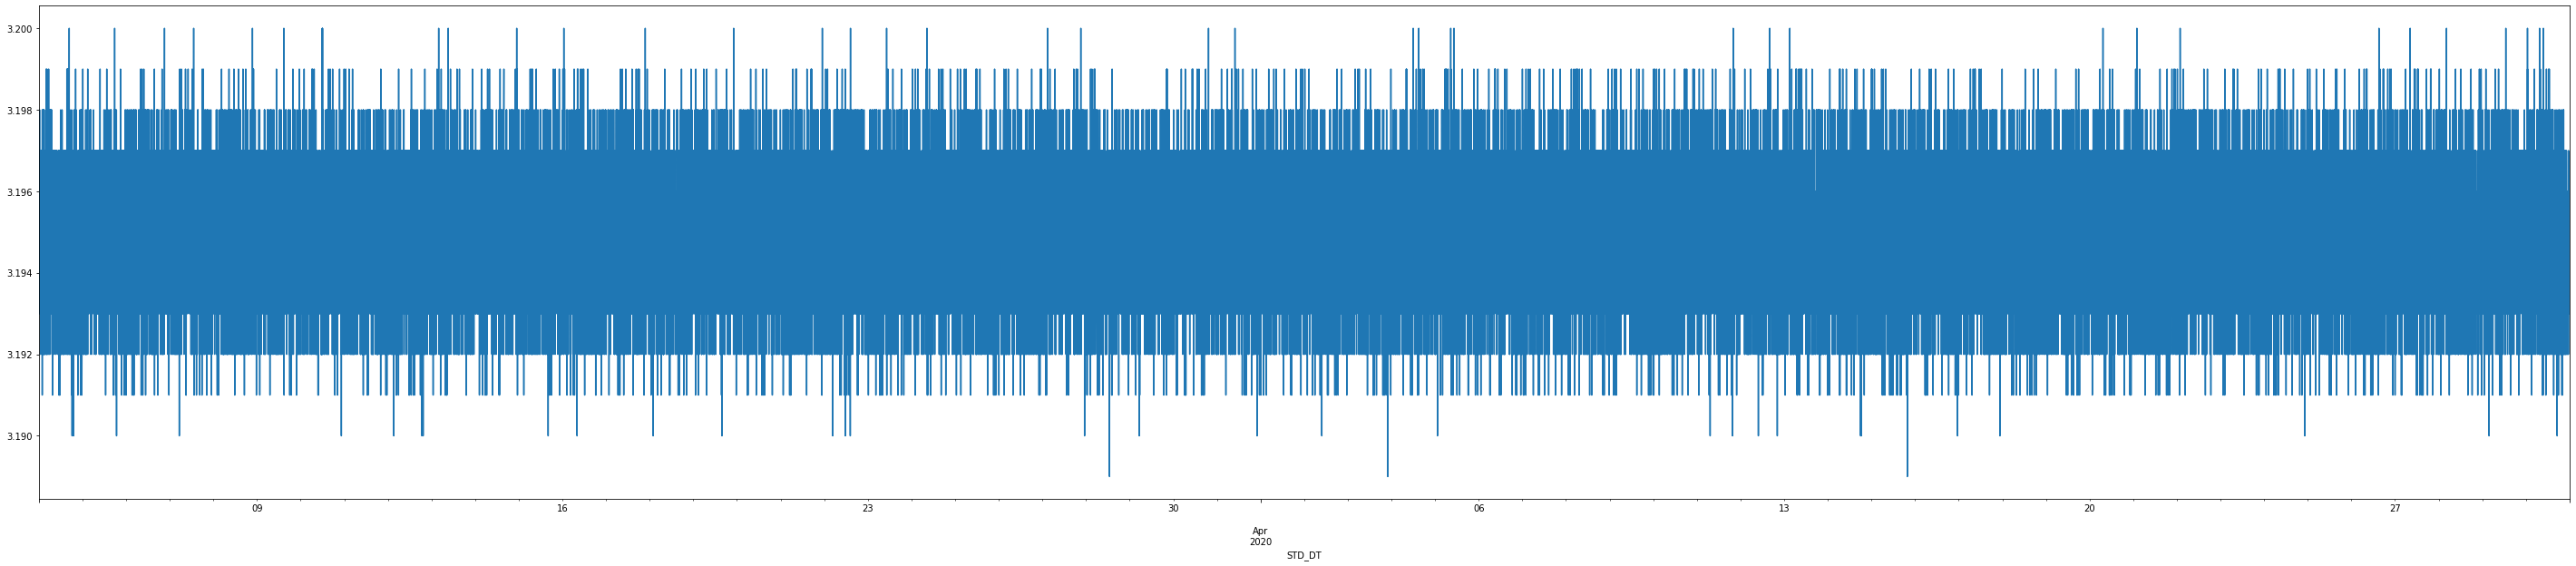

In [59]:
data_dy.resample('T').mean()['INSP'].plot(figsize=(50,10))

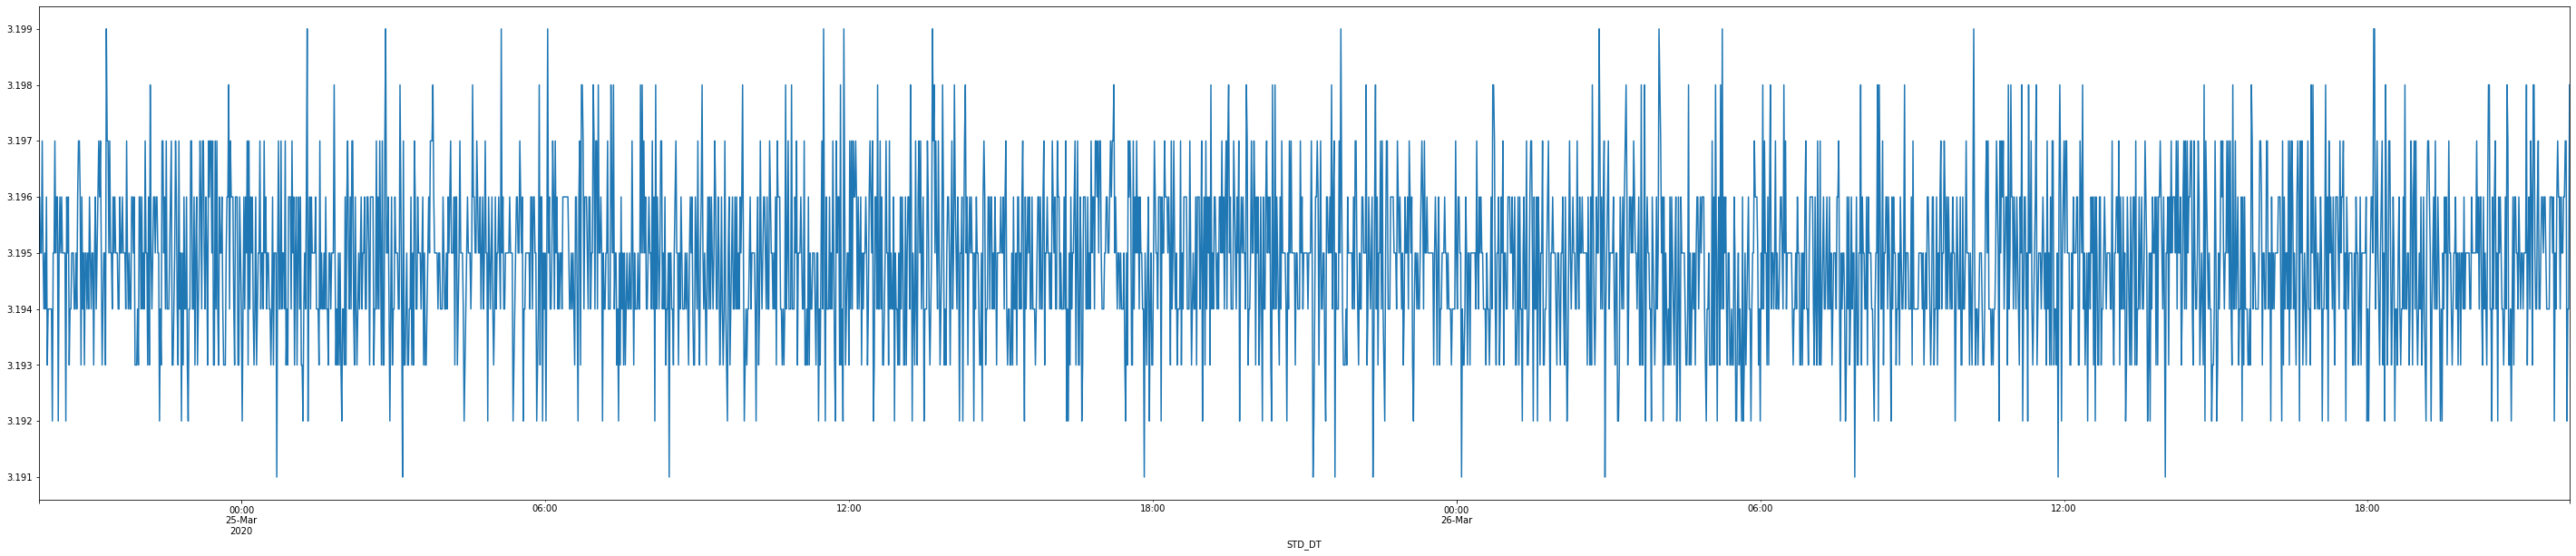

In [61]:
data_dy.resample('T').mean()['INSP'].iloc[30000:33000].plot(figsize=(50,10))

In [63]:
data_dy.resample('T').mean().corr()

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP       TAG
NUM          1.000000   0.004076   -0.005301     0.140051 -0.004409 -0.133854
MELT_TEMP    0.004076   1.000000    0.003145    -0.001322  0.004387 -0.048166
MOTORSPEED  -0.005301   0.003145    1.000000    -0.000854 -0.000168 -0.003869
MELT_WEIGHT  0.140051  -0.001322   -0.000854     1.000000 -0.002407  0.032134
INSP        -0.004409   0.004387   -0.000168    -0.002407  1.000000  0.004744
TAG         -0.133854  -0.048166   -0.003869     0.032134  0.004744  1.000000

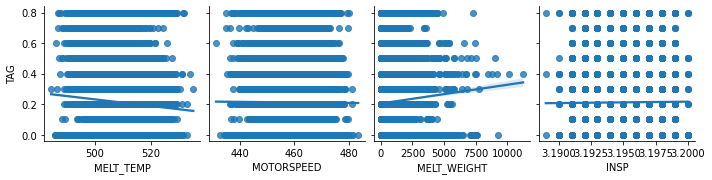

In [72]:
sns.pairplot(data=data_dy.resample('T').mean(), y_vars = 'TAG', x_vars = data_dy.columns[1:-1], kind='reg')

In [73]:
data_dy.resample('H').mean().corr()

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP       TAG
NUM          1.000000   0.031489   -0.040712     0.215045 -0.034085 -0.136746
MELT_TEMP    0.031489   1.000000    0.016860    -0.010347 -0.001245  0.017490
MOTORSPEED  -0.040712   0.016860    1.000000     0.009314 -0.052917 -0.008285
MELT_WEIGHT  0.215045  -0.010347    0.009314     1.000000 -0.002434  0.051033
INSP        -0.034085  -0.001245   -0.052917    -0.002434  1.000000  0.040463
TAG         -0.136746   0.017490   -0.008285     0.051033  0.040463  1.000000

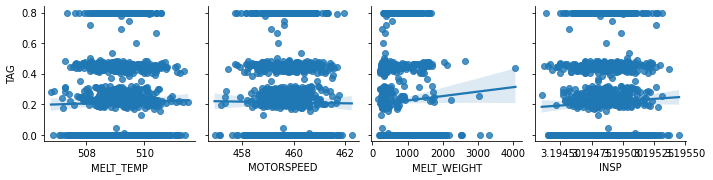

In [74]:
sns.pairplot(data=data_dy.resample('H').mean(), y_vars = 'TAG', x_vars = data_dy.columns[1:-1], kind='reg')

### 베이스라인

In [84]:
train.shape, test.shape

((584640, 7), (250560, 7))

In [92]:
X_test = test[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']]
y_test = test['TAG']

In [85]:
train.columns

Index(['STD_DT', 'NUM', 'MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP',
       'TAG'],
      dtype='object')

In [87]:
X = train[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']]
y = train['TAG']

In [88]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

In [98]:
scores = cross_val_score(rf , X , y ,scoring ='f1', cv=3)
scores

array([0.50022611, 0.46932907, 0.44774574])

In [93]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

# 정밀도 False Positive 문제가 발생한다.
  # 참 예측성능이 나쁜편

오차 행렬
[[174769  72848]
 [  1050   1893]]
정확도: 0.7051, 정밀도: 0.0253, 재현율: 0.6432, F1: 0.0487


In [104]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [105]:
lr_clf = LogisticRegression() 
lr_clf.fit(X_scaled, y)

LogisticRegression()

In [123]:
scores = cross_val_score(lr_clf , X_scaled , y ,scoring ='recall', cv=3)
scores

array([0.55683052, 0.31122827, 0.18586541])

In [124]:
scores = cross_val_score(lr_clf , X_scaled , y ,scoring ='precision', cv=3)
scores

array([0.45923326, 0.51504006, 0.4212746 ])

In [106]:
X_test_scaled = scaler.transform(X_test)

In [107]:
pred = lr_clf.predict(X_test_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[190020  57597]
 [  1567   1376]]
정확도: 0.7639, 정밀도: 0.0233, 재현율: 0.4676, F1: 0.0444


### SMOTE

In [112]:
y.value_counts(normalize=True)

0    0.702169
1    0.297831
Name: TAG, dtype: float64

In [125]:
smote = SMOTE(random_state=0)
X_over, y_over = smote.fit_resample(X, y)

smote = SMOTE(random_state=1)
X_scaled_over, y_scaled_over = smote.fit_resample(X_scaled, y)

In [115]:
y_over.value_counts()

0    410516
1    410516
Name: TAG, dtype: int64

In [126]:
y_scaled_over.value_counts()

0    410516
1    410516
Name: TAG, dtype: int64

In [116]:
rf = RandomForestClassifier()
rf.fit(X_over, y_over)

RandomForestClassifier()

In [118]:
scores = cross_val_score(rf , X_over , y_over ,scoring ='f1', cv=3)
scores

array([0.70628017, 0.84158788, 0.88415856])

In [135]:
rf.feature_importances_

array([0.36238377, 0.19994083, 0.30863761, 0.12903779])

In [117]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[159762  87855]
 [   726   2217]]
정확도: 0.6465, 정밀도: 0.0246, 재현율: 0.7533, F1: 0.0477


In [119]:
scaler = StandardScaler()
scaler.fit(X_over)
X_over_scaled = scaler.transform(X_over)

In [128]:
lr_clf = LogisticRegression() 
lr_clf.fit(X_scaled_over, y_scaled_over)

LogisticRegression()

In [131]:
scores = cross_val_score(lr_clf , X_scaled_over , y_scaled_over ,scoring ='f1', cv=3)
scores

array([0.69816311, 0.78669869, 0.79710578])

In [129]:
pred = lr_clf.predict(X_test_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[134517 113100]
 [   264   2679]]
정확도: 0.5476, 정밀도: 0.0231, 재현율: 0.9103, F1: 0.0451


### 파생변수 추가

In [21]:
train['STD_DT'] = train['STD_DT'].apply(lambda x : pd.to_datetime(x))
train_dy = train.set_index('STD_DT')

/var/folders/54/1kvtx3bn6v3c82sc7wg7yvdw0000gn/T/ipykernel_3433/96220387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['STD_DT'] = train['STD_DT'].apply(lambda x : pd.to_datetime(x))


In [7]:
train_dy_t = train_dy.rolling(10).mean()[['MELT_TEMP',	'MOTORSPEED','MELT_WEIGHT','INSP']].fillna(method='bfill')
train_dy_t.columns = ['MELT_TEMP_T',	'MOTORSPEED_T','MELT_WEIGHT_T','INSP_T']

In [8]:
train_dy_tc = ((train_dy_t - train_dy_t.shift(9).fillna(method='bfill')) / train_dy_t) * 100
train_dy_tc.columns = ['MELT_TEMP_TC',	'MOTORSPEED_TC','MELT_WEIGHT_TC','INSP_TC']

In [9]:
train_add = pd.concat([train_dy, train_dy_t, train_dy_tc], axis=1)

In [10]:
train_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584640 entries, 2020-03-04 00:00:00 to 2020-04-13 14:23:00
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   NUM             584640 non-null  int64  
 1   MELT_TEMP       584640 non-null  int64  
 2   MOTORSPEED      584640 non-null  int64  
 3   MELT_WEIGHT     584640 non-null  int64  
 4   INSP            584640 non-null  float64
 5   TAG             584640 non-null  int64  
 6   MELT_TEMP_T     584640 non-null  float64
 7   MOTORSPEED_T    584640 non-null  float64
 8   MELT_WEIGHT_T   584640 non-null  float64
 9   INSP_T          584640 non-null  float64
 10  MELT_TEMP_TC    584640 non-null  float64
 11  MOTORSPEED_TC   584640 non-null  float64
 12  MELT_WEIGHT_TC  584640 non-null  float64
 13  INSP_TC         584640 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 66.9 MB


In [11]:
train_add.columns

Index(['NUM', 'MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG',
       'MELT_TEMP_T', 'MOTORSPEED_T', 'MELT_WEIGHT_T', 'INSP_T',
       'MELT_TEMP_TC', 'MOTORSPEED_TC', 'MELT_WEIGHT_TC', 'INSP_TC'],
      dtype='object')

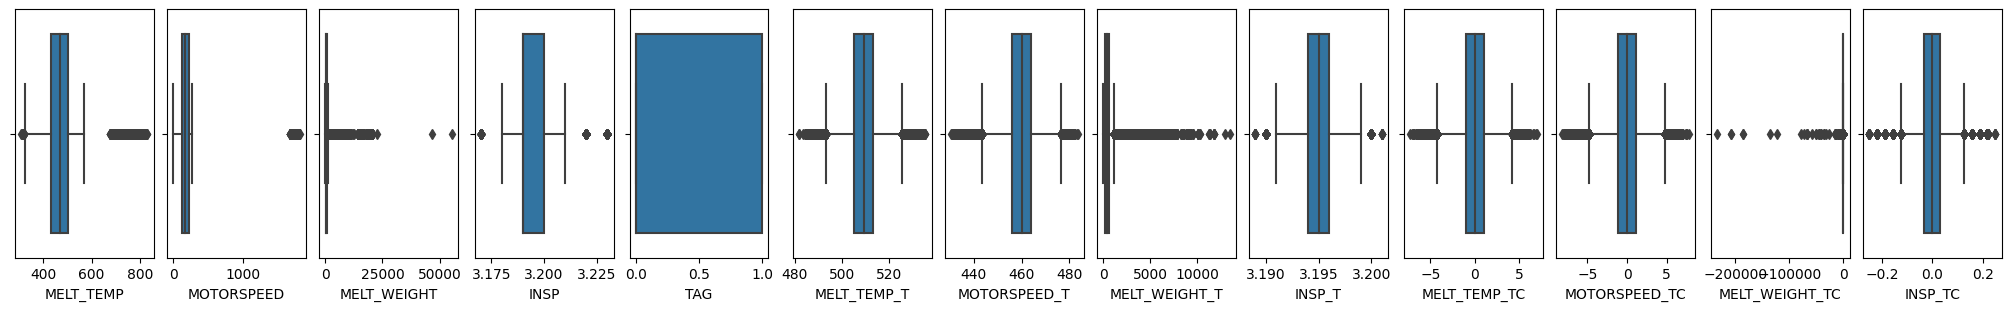

In [25]:
li = train_add.columns[1:]

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=len(li), constrained_layout=True)

for idx, col in enumerate(li) :
    sns.boxplot(data=train_add, x= col, ax = axs[idx])

In [26]:
train_add.columns

Index(['NUM', 'MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG',
       'MELT_TEMP_T', 'MOTORSPEED_T', 'MELT_WEIGHT_T', 'INSP_T',
       'MELT_TEMP_TC', 'MOTORSPEED_TC', 'MELT_WEIGHT_TC', 'INSP_TC'],
      dtype='object')

In [20]:
li = ['MELT_TEMP_T', 'MOTORSPEED_T', 'MELT_WEIGHT_T', 'INSP_T', 'MELT_TEMP_TC', 'MOTORSPEED_TC', 'MELT_WEIGHT_TC', 'INSP_TC']

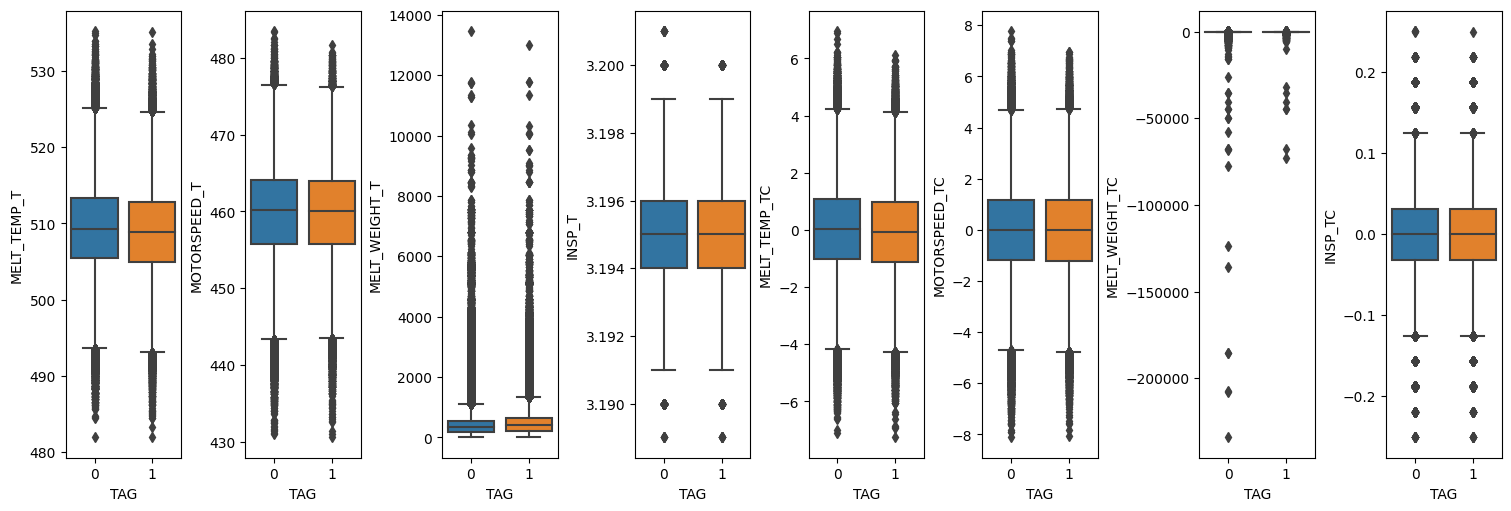

In [26]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=len(li), constrained_layout=True)
for idx, i in enumerate(li) :

    sns.boxplot(data= train_add, y=i, x='TAG', ax = axs[idx])

In [30]:
test['STD_DT'] = test['STD_DT'].apply(lambda x : pd.to_datetime(x))
test_dy = test.set_index('STD_DT')

/var/folders/54/1kvtx3bn6v3c82sc7wg7yvdw0000gn/T/ipykernel_81624/2804372906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['STD_DT'] = test['STD_DT'].apply(lambda x : pd.to_datetime(x))


In [31]:
test_dy_t = test_dy.rolling(10).mean()[['MELT_TEMP',	'MOTORSPEED','MELT_WEIGHT','INSP']].fillna(method='bfill')
test_dy_t.columns = ['MELT_TEMP_T',	'MOTORSPEED_T','MELT_WEIGHT_T','INSP_T']

test_dy_tc = ((test_dy_t - test_dy_t.shift(9).fillna(method='bfill')) / test_dy_t) * 100
test_dy_tc.columns = ['MELT_TEMP_TC',	'MOTORSPEED_TC','MELT_WEIGHT_TC','INSP_TC']

test_add = pd.concat([test_dy, test_dy_t, test_dy_tc], axis=1)

In [32]:
test_add.head(20)

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP  TAG  \
STD_DT                                                                       
2020-04-13 14:24:00  584640        485         128          104  3.19    0   
2020-04-13 14:24:00  584641        428          77          102  3.19    1   
2020-04-13 14:24:00  584642        450         168          101  3.19    1   
2020-04-13 14:24:00  584643        361         186           99  3.18    0   
2020-04-13 14:24:00  584644        763        1753           98  3.22    0   
2020-04-13 14:24:00  584645        748        1722           96  3.21    0   
2020-04-13 14:24:00  584646        416         218           94  3.18    0   
2020-04-13 14:24:00  584647        484         186           93  3.19    0   
2020-04-13 14:24:00  584648        447          71           91  3.19    1   
2020-04-13 14:24:00  584649        513         142           90  3.20    0   
2020-04-13 14:25:00  584650        457         109           88  3.19    1   
2020-04-13 14:25:00  584651        459          73           87  3.20    1   
2020-04-13 14:25:00  584652        488         177           85  3.19    0   
2020-04-13 14:25:00  584653        406         178           84  3.18    0   
2020-04-13 14:25:00  584654        732        1729           82  3.22    0   
2020-04-13 14:25:00  584655        784        1726           80  3.21    0   
2020-04-13 14:25:00  584656        365         219           79  3.19    0   
2020-04-13 14:25:00  584657        466         183           77  3.19    0   
2020-04-13 14:25:00  584658        420          62           76  3.19    1   
2020-04-13 14:25:00  584659        471         133           74  3.19    0   

                     MELT_TEMP_T  MOTORSPEED_T  MELT_WEIGHT_T  INSP_T  \
STD_DT                                                                  
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:24:00        509.5         465.1           96.8   3.194   
2020-04-13 14:25:00        506.7         463.2           95.2   3.194   
2020-04-13 14:25:00        509.8         462.8           93.7   3.195   
2020-04-13 14:25:00        513.6         463.7           92.1   3.195   
2020-04-13 14:25:00        518.1         462.9           90.6   3.195   
2020-04-13 14:25:00        515.0         460.5           89.0   3.195   
2020-04-13 14:25:00        518.6         460.9           87.4   3.195   
2020-04-13 14:25:00        513.5         461.0           85.9   3.196   
2020-04-13 14:25:00        511.7         460.7           84.3   3.196   
2020-04-13 14:25:00        509.0         459.8           82.8   3.196   
2020-04-13 14:25:00        504.8         458.9           81.2   3.195   

                     MELT_TEMP_TC  MOTORSPEED_TC  MELT_WEIGHT_TC   INSP_TC  
STD_DT                                                                      
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04-13 14:24:00      0.000000       0.000000        0.000000  0.000000  
2020-04

In [33]:
X = train_add.drop(columns=['NUM', 'TAG'])
y = train_add['TAG']

In [34]:
X_test = test_add.drop(columns=['NUM', 'TAG'])
y_test = test_add['TAG']

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584640 entries, 2020-03-04 00:00:00 to 2020-04-13 14:23:00
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MELT_TEMP       584640 non-null  int64  
 1   MOTORSPEED      584640 non-null  int64  
 2   MELT_WEIGHT     584640 non-null  int64  
 3   INSP            584640 non-null  float64
 4   MELT_TEMP_T     584640 non-null  float64
 5   MOTORSPEED_T    584640 non-null  float64
 6   MELT_WEIGHT_T   584640 non-null  float64
 7   INSP_T          584640 non-null  float64
 8   MELT_TEMP_TC    584640 non-null  float64
 9   MOTORSPEED_TC   584640 non-null  float64
 10  MELT_WEIGHT_TC  584640 non-null  float64
 11  INSP_TC         584640 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 58.0 MB


In [36]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

<AxesSubplot:>

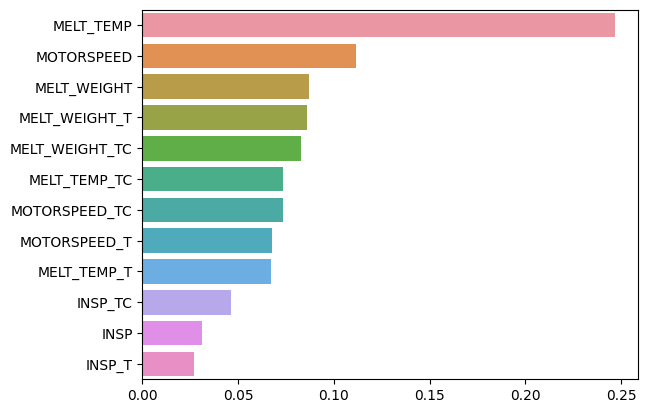

In [39]:
feature_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [62]:
scores = cross_val_score(rf , X , y ,scoring ='f1', cv=3)
scores

array([0.49104697, 0.50237384, 0.34312976])

In [61]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[172152  75465]
 [   548   2395]]
정확도: 0.6966, 정밀도: 0.0308, 재현율: 0.8138, F1: 0.0593


In [23]:
data_ts = data.set_index('STD_DT')

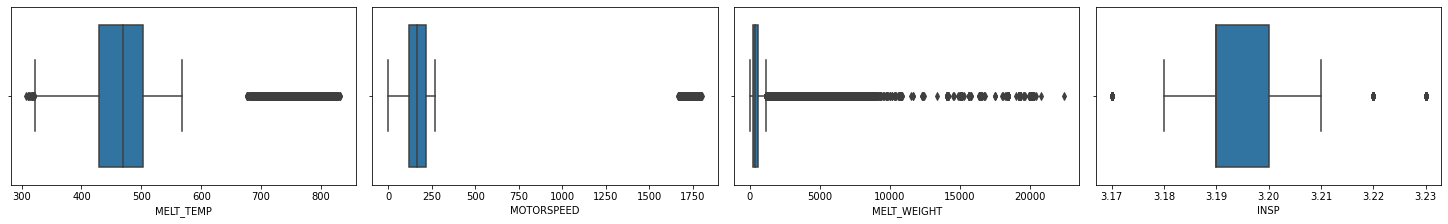

In [ ]:
# 이상치 제거한 데이터 다시 시각화
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.boxplot(data=data_p, x= col, ax = axs[idx])

In [24]:
# 너무 큰 melt_w 제거 : 이상체 제거
data_p = data.drop(index= outlier)
data_p = data_p.reset_index(drop='True')
data_p.shape

(835194, 7)

In [24]:
outlier = data[data['MELT_WEIGHT'] >= 25000].index 
print(len(outlier))

6


<AxesSubplot:xlabel='STD_DT'>

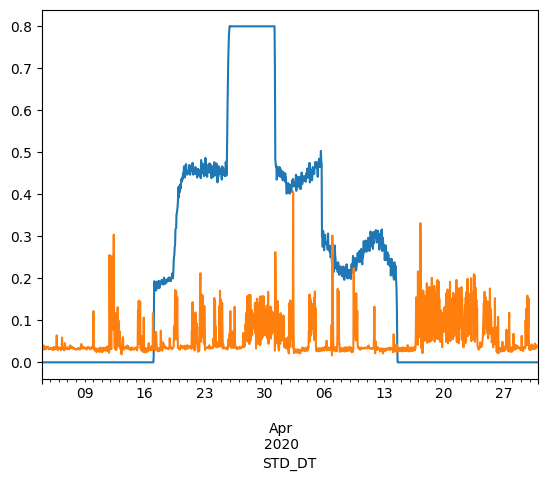

In [25]:
data_ts.resample('H').mean()['TAG'].plot()
(data_ts.resample('H').mean()['MELT_WEIGHT']/10000).plot()

<AxesSubplot:xlabel='STD_DT'>

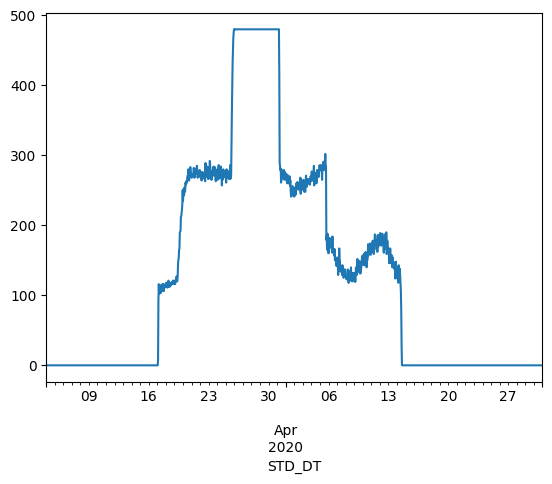

In [26]:
data_ts.resample('H').sum()['TAG'].plot()

In [28]:
data_ts.resample('H').mean()

NUM   MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP  \
STD_DT                                                                         
2020-03-04 00:00:00     299.5  509.631667  459.305000   331.983333  3.194950   
2020-03-04 01:00:00     899.5  508.148333  459.366667   316.873333  3.194850   
2020-03-04 02:00:00    1499.5  507.846667  459.173333   377.843333  3.195017   
2020-03-04 03:00:00    2099.5  509.446667  459.706667   385.510000  3.194633   
2020-03-04 04:00:00    2699.5  509.758333  458.400000   312.081667  3.194767   
...                       ...         ...         ...          ...       ...   
2020-04-30 19:00:00  832499.5  510.483333  460.550000   406.791667  3.194783   
2020-04-30 20:00:00  833099.5  508.960000  459.576667   379.865000  3.194850   
2020-04-30 21:00:00  833699.5  508.451667  460.765000   398.168333  3.194550   
2020-04-30 22:00:00  834299.5  509.886667  458.955000   361.036667  3.194683   
2020-04-30 23:00:00  834899.5  509.243333  459.515000   376.633333  3.194500   

                     TAG  
STD_DT                    
2020-03-04 00:00:00  0.0  
2020-03-04 01:00:00  0.0  
2020-03-04 02:00:00  0.0  
2020-03-04 03:00:00  0.0  
2020-03-04 04:00:00  0.0  
...                  ...  
2020-04-30 19:00:00  0.0  
2020-04-30 20:00:00  0.0  
2020-04-30 21:00:00  0.0  
2020-04-30 22:00:00  0.0  
2020-04-30 23:00:00  0.0  

[1392 rows x 6 columns]

In [29]:
data_ts_n.resample('T').mean()['TAG'].plot(figsize=(50,10))
data_ts_n.resample('T').mean().plot(figsize=(50,10))

NameError: name 'data_ts_n' is not defined

In [ ]:
data_ts_n.resample('H').mean()

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP  TAG
STD_DT                                                                
2020-03-04 00:00:00   0.496686    0.537669     0.029411  0.540909  0.0
2020-03-04 01:00:00   0.467487    0.538857     0.028070  0.531818  0.0
2020-03-04 02:00:00   0.461549    0.535132     0.033481  0.546970  0.0
2020-03-04 03:00:00   0.493045    0.545408     0.034161  0.512121  0.0
2020-03-04 04:00:00   0.499180    0.520231     0.027645  0.524242  0.0
...                        ...         ...          ...       ...  ...
2020-04-30 19:00:00   0.513451    0.561657     0.036050  0.525758  0.0
2020-04-30 20:00:00   0.483465    0.542903     0.033660  0.531818  0.0
2020-04-30 21:00:00   0.473458    0.565800     0.035285  0.504545  0.0
2020-04-30 22:00:00   0.501706    0.530925     0.031989  0.516667  0.0
2020-04-30 23:00:00   0.489042    0.541715     0.033374  0.500000  0.0

[1392 rows x 5 columns]

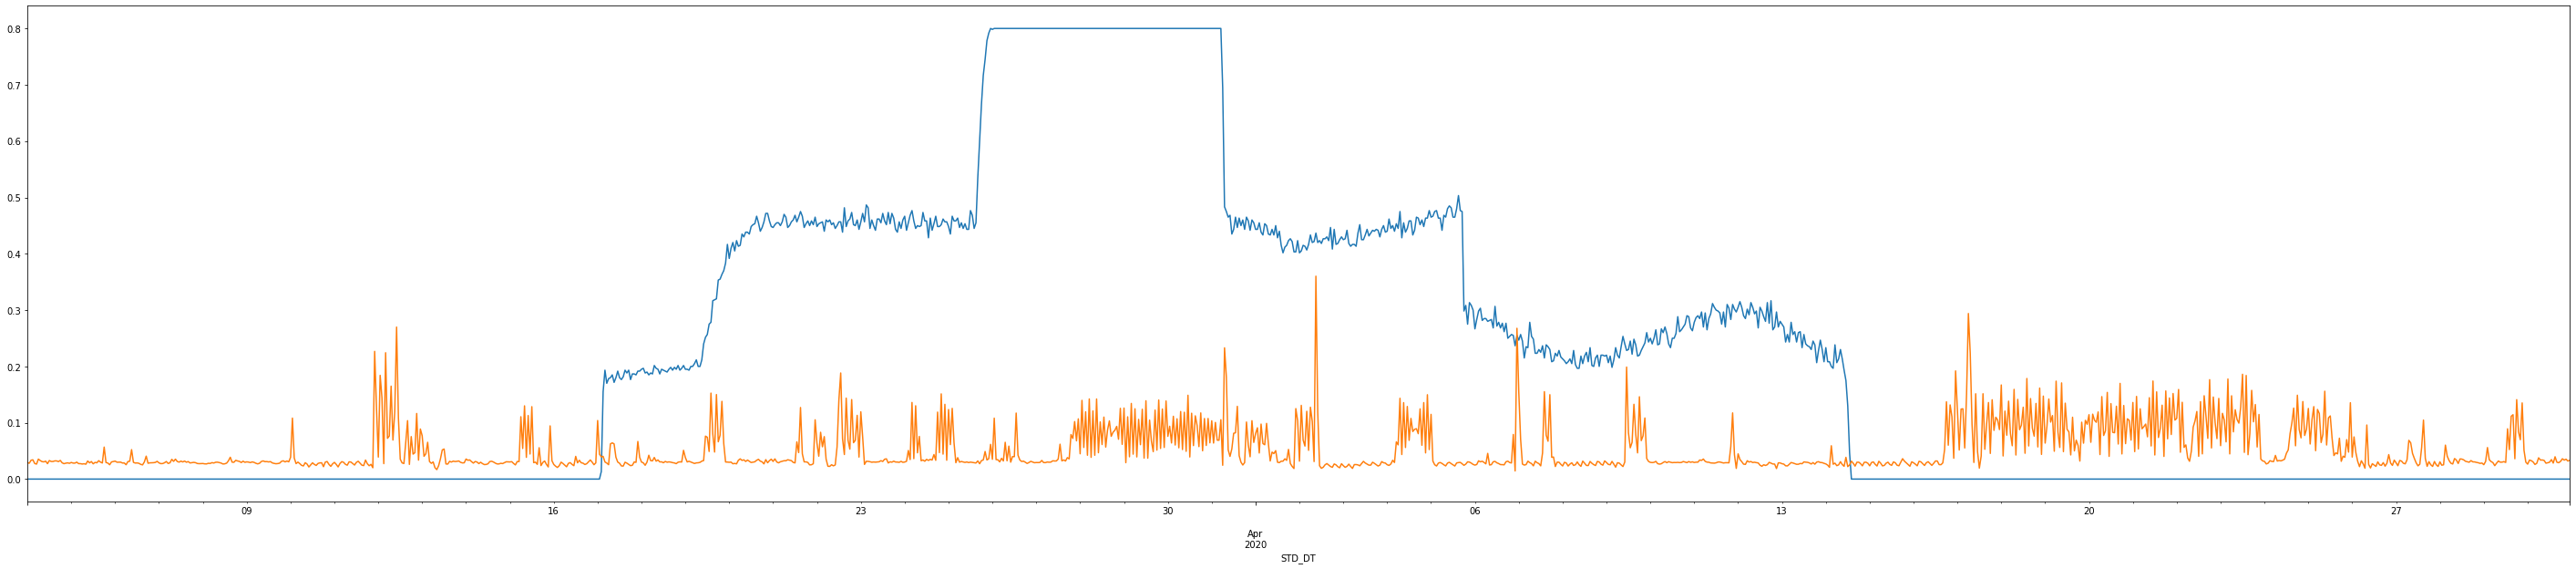

In [ ]:
data_ts_n.resample('H').mean()['TAG'].plot(figsize=(50,10))
data_ts_n.resample('H').mean()['MELT_WEIGHT'].plot(figsize=(50,10))

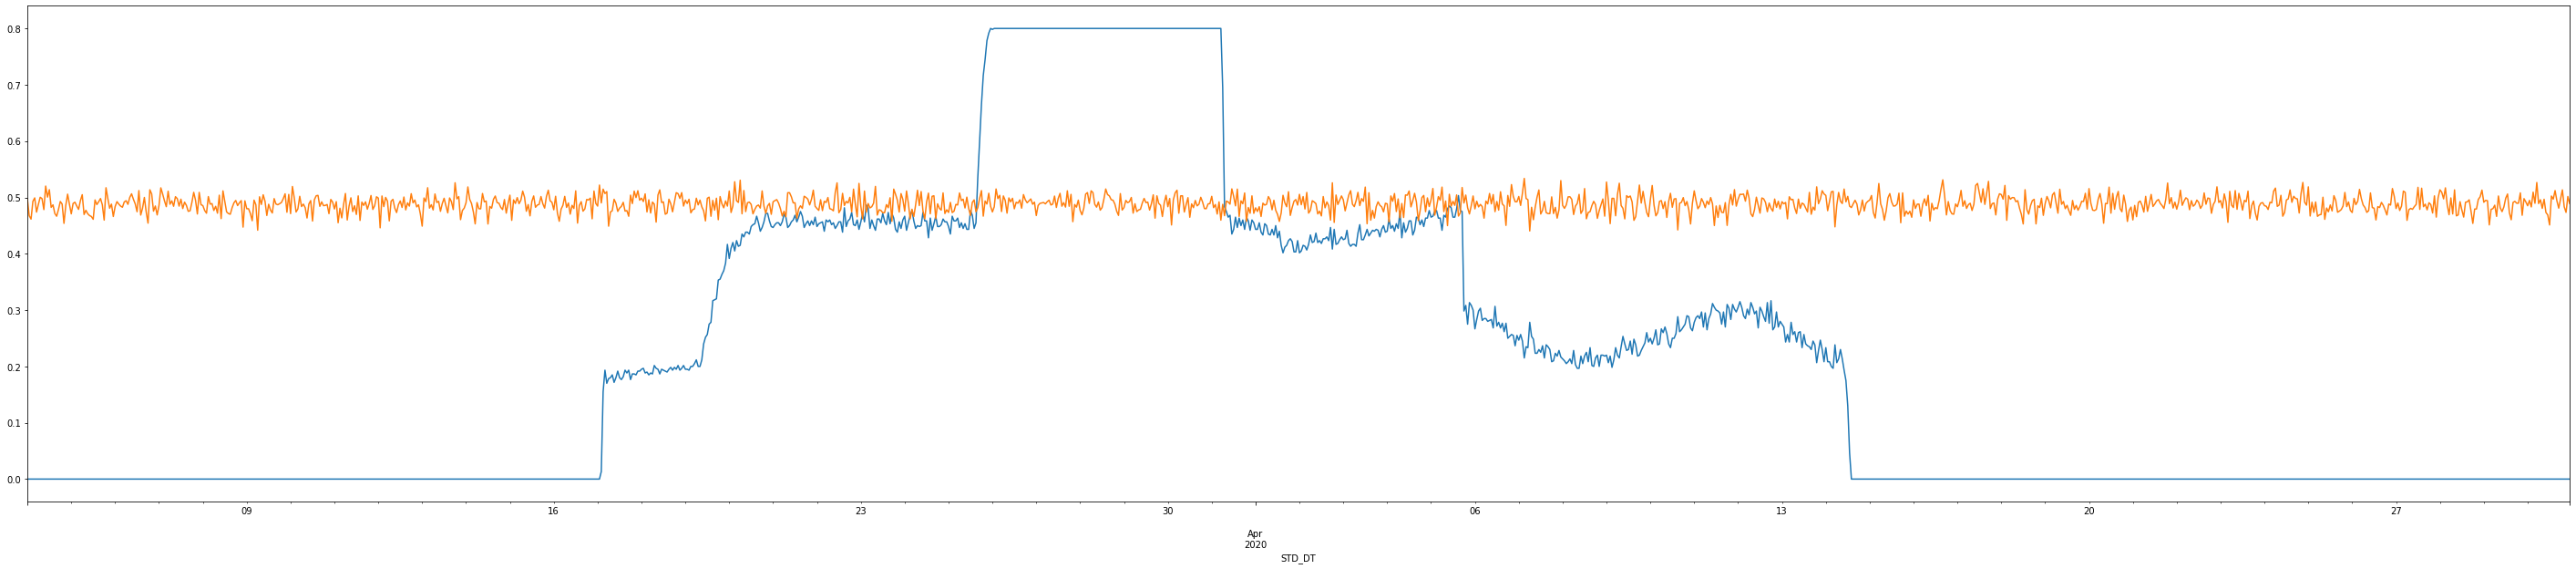

In [ ]:
data_ts_n.resample('H').mean()['TAG'].plot(figsize=(50,10))
data_ts_n.resample('H').mean()['MELT_TEMP'].plot(figsize=(50,10))

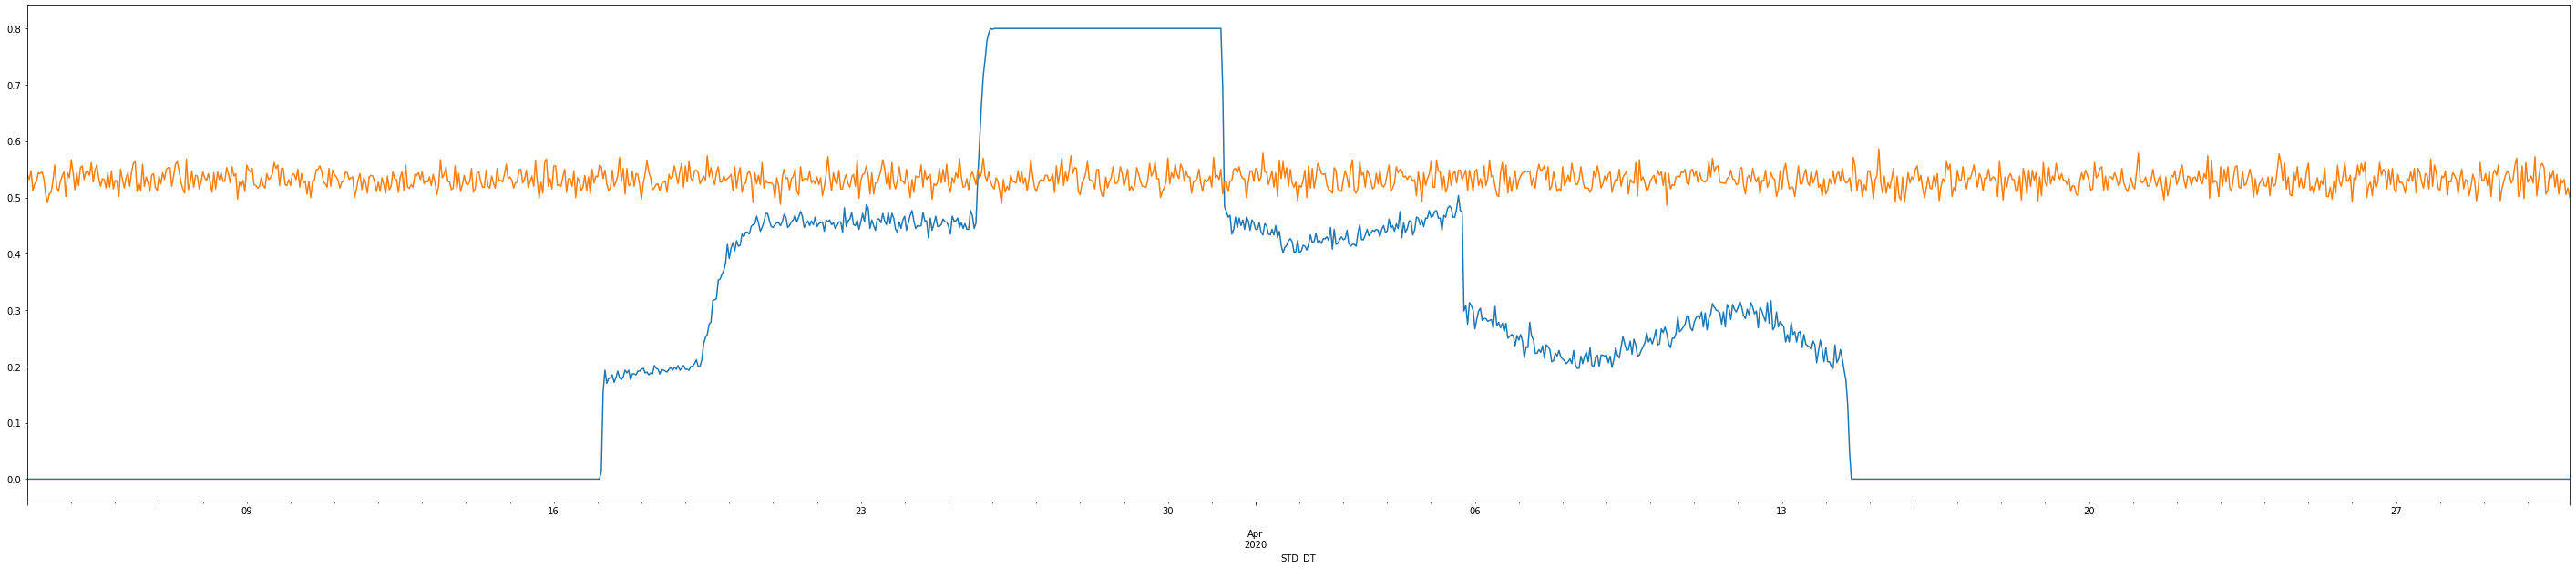

In [ ]:
data_ts_n.resample('H').mean()['TAG'].plot(figsize=(50,10))
data_ts_n.resample('H').mean()['INSP'].plot(figsize=(50,10))

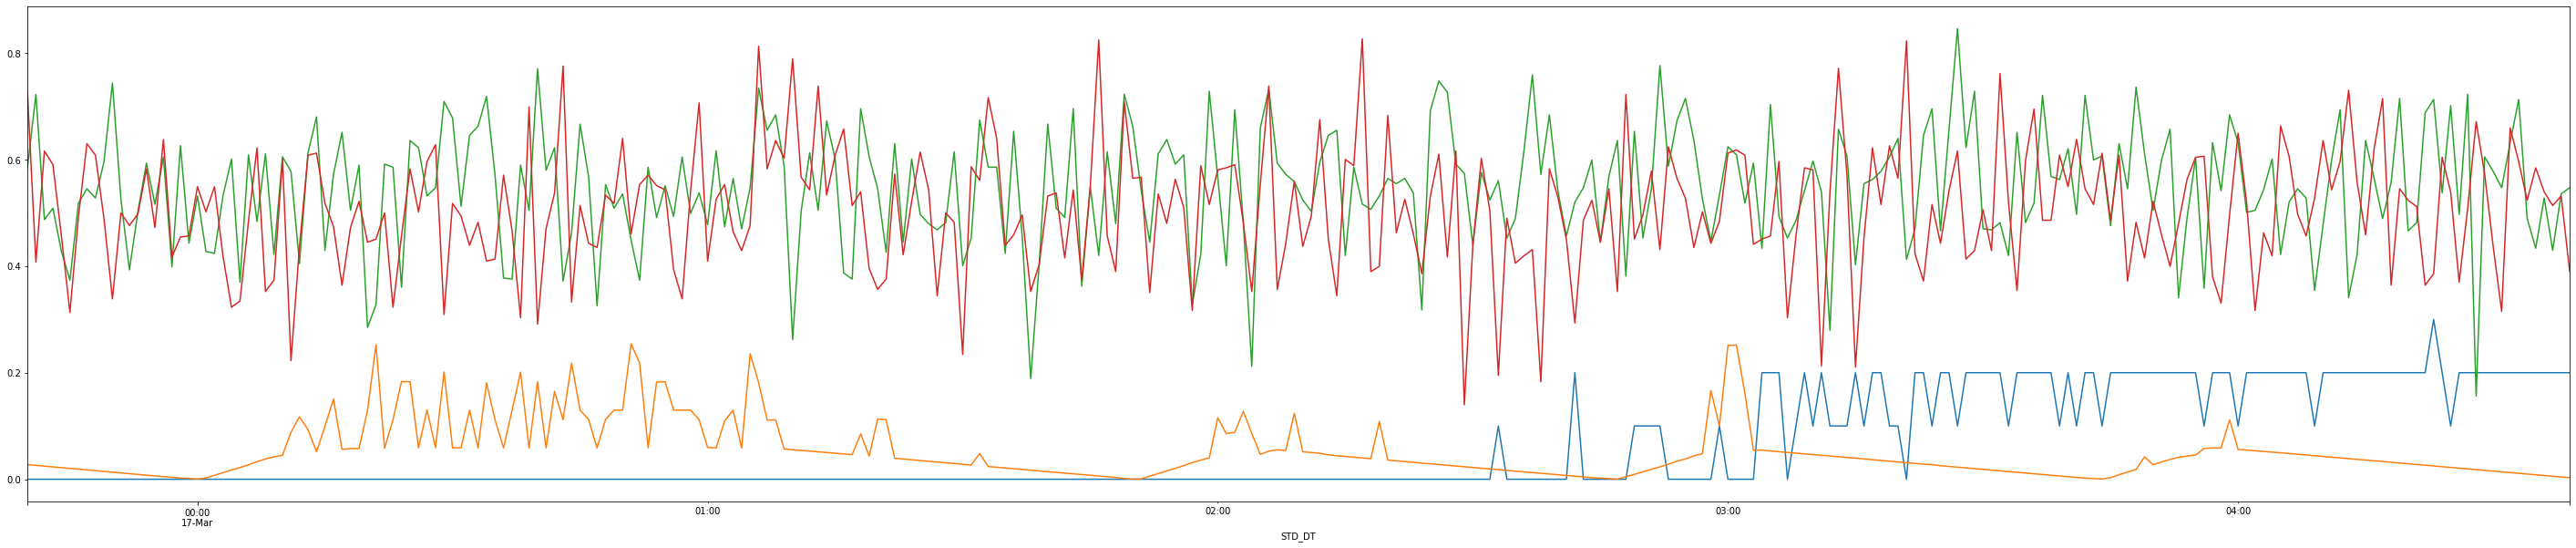

In [ ]:
data_ts_n.resample('T').mean()['TAG'].iloc[18700:19000].plot(figsize=(50,10))
data_ts_n.resample('T').mean()['MELT_WEIGHT'].iloc[18700:19000].plot(figsize=(50,10))
data_ts_n.resample('T').mean()['MOTORSPEED'].iloc[18700:19000].plot(figsize=(50,10))
data_ts_n.resample('T').mean()['MELT_TEMP'].iloc[18700:19000].plot(figsize=(50,10))

In [ ]:
data_ts_n.resample('T').mean()['TAG'].iloc[18000:20000].plot(figsize=(50,10))
data_ts_n.resample('T').mean()['MELT_WEIGHT'].iloc[18000:20000].plot(figsize=(50,10))

### 변수추가
- 딱히 시계열에서 인사이트를 찾지 못했습니다. 그래도 머신러닝이 찾아주겠죠


In [ ]:
data_add_1 = data_ts.rolling(10).mean()[['MELT_TEMP',	'MOTORSPEED','MELT_WEIGHT','INSP']].fillna(method='bfill')

In [ ]:
data_add_1.columns = ['MELT_TEMP_10',	'MOTORSPEED_10','MELT_WEIGHT_10','INSP_10']

In [ ]:
data_add_2 = ((data_add_1 - data_add_1.shift(9).fillna(method='bfill')) / data_add_1) * 100

In [ ]:
data_add_2.columns = ['MELT_TEMP_10_c',	'MOTORSPEED_10_c','MELT_WEIGHT_10_c','INSP_10_c']

In [ ]:
data_add_2 = data_add_2[['MELT_TEMP_10_c',	'MOTORSPEED_10_c','INSP_10_c']]

In [ ]:
data_add = pd.concat([data_ts, data_add_1, data_add_2], axis=1)

In [ ]:
data_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:00
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NUM              835200 non-null  int64  
 1   MELT_TEMP        835200 non-null  int64  
 2   MOTORSPEED       835200 non-null  int64  
 3   MELT_WEIGHT      835200 non-null  int64  
 4   INSP             835200 non-null  float64
 5   TAG              835200 non-null  int64  
 6   MELT_TEMP_10     835200 non-null  float64
 7   MOTORSPEED_10    835200 non-null  float64
 8   MELT_WEIGHT_10   835200 non-null  float64
 9   INSP_10          835200 non-null  float64
 10  MELT_TEMP_10_c   835200 non-null  float64
 11  MOTORSPEED_10_c  835200 non-null  float64
 12  INSP_10_c        835200 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 121.5 MB


In [ ]:
X_a = data_add.drop(columns=['NUM', 'TAG'])

In [ ]:
data_add_1 - data_add_1.shift(9).fillna(method='bfill')

MELT_TEMP_10  MOTORSPEED_10  MELT_WEIGHT_10  INSP_10
STD_DT                                                                   
2020-03-04 00:00:00           0.0            0.0             0.0    0.000
2020-03-04 00:00:00           0.0            0.0             0.0    0.000
2020-03-04 00:00:00           0.0            0.0             0.0    0.000
2020-03-04 00:00:00           0.0            0.0             0.0    0.000
2020-03-04 00:00:00           0.0            0.0             0.0    0.000
...                           ...            ...             ...      ...
2020-04-30 23:59:00          -1.1           13.1           -10.3   -0.003
2020-04-30 23:59:00          -7.3            4.6           -10.3   -0.003
2020-04-30 23:59:00          -6.8           -5.7           -10.3   -0.002
2020-04-30 23:59:00          -2.6          -11.8           -10.4   -0.001
2020-04-30 23:59:00          -6.2          -10.6           -10.5   -0.001

[835200 rows x 4 columns]

In [ ]:
data_add_1

MELT_TEMP_10  MOTORSPEED_10  MELT_WEIGHT_10  INSP_10
STD_DT                                                                   
2020-03-04 00:00:00         510.5          453.0           606.0    3.195
2020-03-04 00:00:00         510.5          453.0           606.0    3.195
2020-03-04 00:00:00         510.5          453.0           606.0    3.195
2020-03-04 00:00:00         510.5          453.0           606.0    3.195
2020-03-04 00:00:00         510.5          453.0           606.0    3.195
...                           ...            ...             ...      ...
2020-04-30 23:59:00         512.1          467.6           322.9    3.194
2020-04-30 23:59:00         512.1          463.8           321.8    3.194
2020-04-30 23:59:00         507.4          460.7           320.7    3.195
2020-04-30 23:59:00         513.4          453.5           319.5    3.195
2020-04-30 23:59:00         509.7          455.5           318.2    3.196

[835200 rows x 4 columns]

In [ ]:
data_ts.shift(10)

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP  TAG
STD_DT                                                                      
2020-03-04 00:00:00       NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04 00:00:00       NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04 00:00:00       NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04 00:00:00       NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04 00:00:00       NaN        NaN         NaN          NaN   NaN  NaN
...                       ...        ...         ...          ...   ...  ...
2020-04-30 23:59:00  835185.0      783.0      1747.0        329.0  3.22  0.0
2020-04-30 23:59:00  835186.0      385.0       244.0        328.0  3.19  0.0
2020-04-30 23:59:00  835187.0      512.0       179.0        327.0  3.19  0.0
2020-04-30 23:59:00  835188.0      407.0        72.0        326.0  3.19  0.0
2020-04-30 23:59:00  835189.0      490.0       105.0        325.0  3.19  0.0

[835200 rows x 6 columns]

In [ ]:
data_ts.shift(10).head(10)


NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP  TAG
STD_DT                                                        
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN
2020-03-04  NaN        NaN         NaN          NaN   NaN  NaN

In [ ]:
# findata.shift(900, freq='D')


data_ts_c = (data_ts[['MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP']] - data_ts.shift(1)[['MELT_TEMP','MOTORSPEED','MELT_WEIGHT','INSP']].fillna(0)).iloc[11:]

In [ ]:
data_ts_c

MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP
STD_DT                                                       
2020-03-04 00:01:00      -99.0       -62.0         -1.0  0.00
2020-03-04 00:01:00       66.0        72.0         -1.0  0.00
2020-03-04 00:01:00     -116.0        63.0         -2.0  0.00
2020-03-04 00:01:00      382.0      1539.0         -2.0  0.03
2020-03-04 00:01:00       32.0       -11.0         -2.0  0.00
...                        ...         ...          ...   ...
2020-04-30 23:59:00        6.0         3.0         -1.0  0.00
2020-04-30 23:59:00     -370.0     -1537.0         -1.0 -0.02
2020-04-30 23:59:00       80.0       -58.0         -1.0  0.01
2020-04-30 23:59:00        2.0      -148.0         -2.0 -0.01
2020-04-30 23:59:00      -14.0       125.0         -2.0  0.01

[835189 rows x 4 columns]

In [ ]:
data_ts_c.resample('H').mean()

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP
STD_DT                                                           
2020-03-04 00:00:00  -0.027165    0.006791    -0.202037  0.000000
2020-03-04 01:00:00  -0.001667   -0.036667    -0.266667  0.000000
2020-03-04 02:00:00  -0.020000   -0.025000    -0.068333  0.000000
2020-03-04 03:00:00   0.031667    0.058333    -0.110000  0.000017
2020-03-04 04:00:00  -0.068333    0.026667    -0.265000 -0.000017
...                        ...         ...          ...       ...
2020-04-30 19:00:00  -0.016667    0.005000    -0.108333  0.000017
2020-04-30 20:00:00   0.025000   -0.053333    -0.205000 -0.000017
2020-04-30 21:00:00  -0.050000    0.068333    -0.105000  0.000017
2020-04-30 22:00:00   0.033333   -0.033333    -0.113333 -0.000017
2020-04-30 23:00:00  -0.058333   -0.016667    -0.041667  0.000017

[1392 rows x 4 columns]

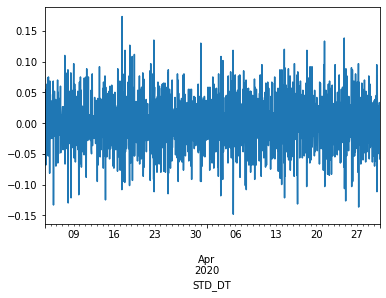

In [ ]:
data_ts_c.resample('H').mean()['MELT_TEMP'].plot()

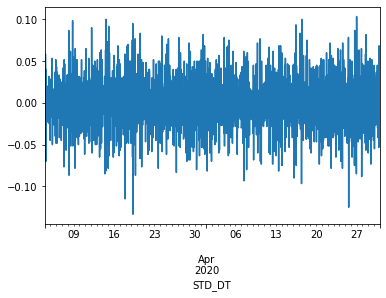

In [ ]:
data_ts_c.resample('H').mean()['MOTORSPEED'].plot()

- 분으로 분석하는게 맞을 것 같습니다

In [ ]:
data_ts.resample('T').mean()['MELT_TEMP',	'MOTORSPEED'	,'MELT_WEIGHT	INSP']

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT   INSP  TAG
STD_DT                                                                       
2020-03-04 00:00:00       4.5      510.5       453.0        606.0  3.195  0.0
2020-03-04 00:01:00      14.5      508.7       448.8        589.2  3.195  0.0
2020-03-04 00:02:00      24.5      505.8       460.5        574.6  3.194  0.0
2020-03-04 00:03:00      34.5      496.2       444.0        560.0  3.194  0.0
2020-03-04 00:04:00      44.5      504.0       463.7        545.2  3.195  0.0
...                       ...        ...         ...          ...    ...  ...
2020-04-30 23:55:00  835154.5      508.4       459.7        372.2  3.194  0.0
2020-04-30 23:56:00  835164.5      508.7       446.7        355.2  3.193  0.0
2020-04-30 23:57:00  835174.5      499.7       445.3        342.3  3.196  0.0
2020-04-30 23:58:00  835184.5      516.0       465.3        329.9  3.196  0.0
2020-04-30 23:59:00  835194.5      509.7       455.5        318.2  3.196  0.0

[83520 rows x 6 columns]

In [ ]:
data_ts.resample('T').mean().describe()

NUM     MELT_TEMP    MOTORSPEED   MELT_WEIGHT          INSP  \
count   83520.000000  83520.000000  83520.000000  83520.000000  83520.000000   
mean   417599.500000    509.200623    459.782865    582.962125      3.194853   
std    241102.915785      5.930101      6.073839    696.211492      0.001404   
min         4.500000    484.400000    431.400000      0.600000      3.189000   
25%    208802.000000    505.200000    455.800000    187.100000      3.194000   
50%    417599.500000    509.200000    460.200000    385.800000      3.195000   
75%    626397.000000    513.200000    464.000000    604.100000      3.196000   
max    835194.500000    535.200000    483.300000  11268.000000      3.200000   

                TAG  
count  83520.000000  
mean       0.212006  
std        0.264738  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.400000  
max        0.800000

In [30]:
data_ts_t = data_ts.resample('H').mean()[['MELT_TEMP',	'MOTORSPEED'	,'MELT_WEIGHT', 'INSP']]

In [31]:
scaler = MinMaxScaler()
scaler.fit(data_ts_t)

MinMaxScaler()

In [35]:
temp = pd.DataFrame(scaler.transform(data_ts_t), index=data_ts_t.index, columns=data_ts_t.columns)
data_ts_n = pd.concat([temp, data_ts.resample('H').mean()['TAG']], axis=1)

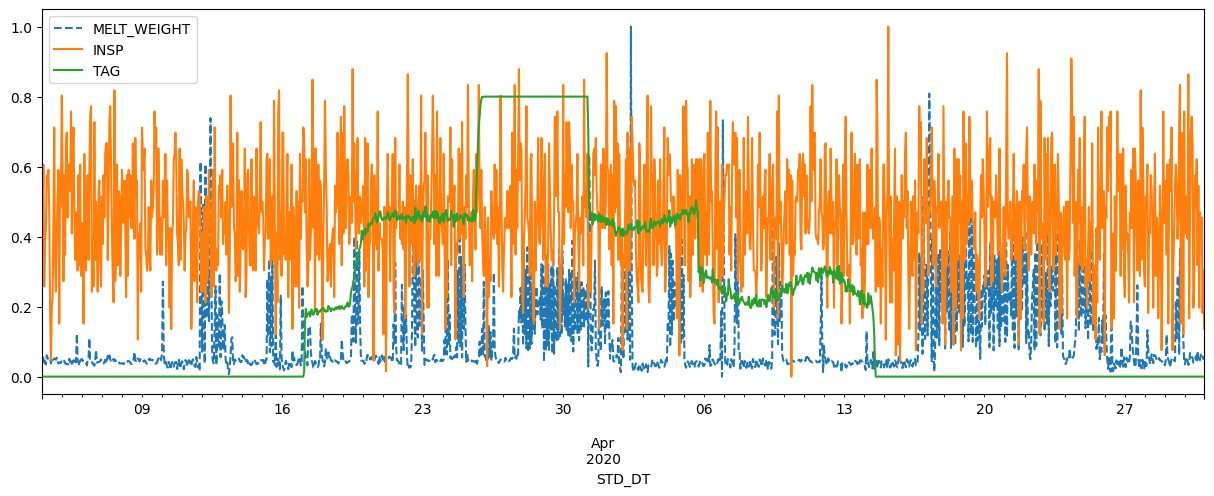

In [53]:
data_ts_n[['MELT_WEIGHT','INSP', 'TAG']].plot(figsize=(15,5),style=['--'])

plt.legend(loc='upper left')

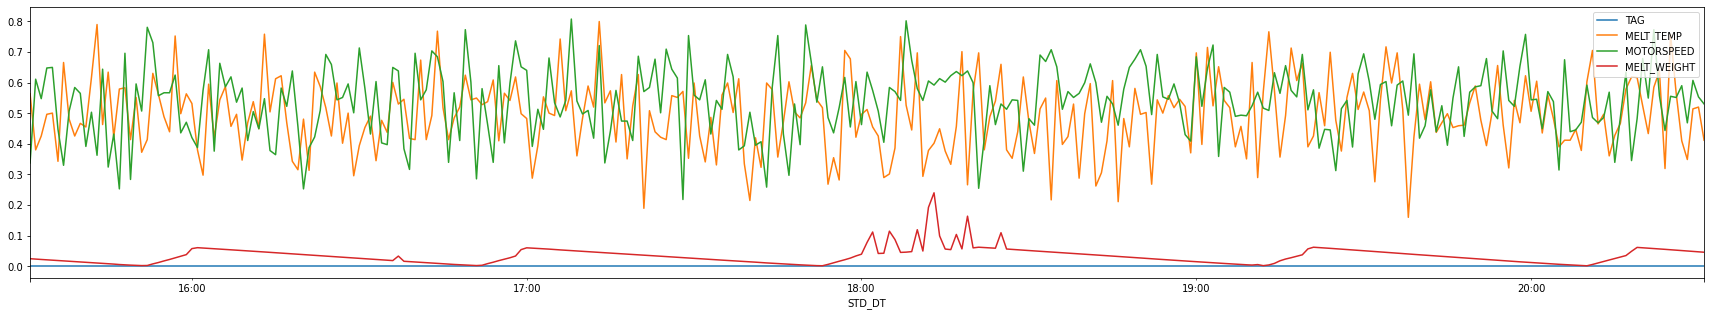

In [ ]:
data_ts_n.loc['2020-03-05 15:31:00' : '2020-03-05 20:31:00'][['TAG','MELT_TEMP','MOTORSPEED','MELT_WEIGHT']].plot(figsize=(30,5))
plt.show()

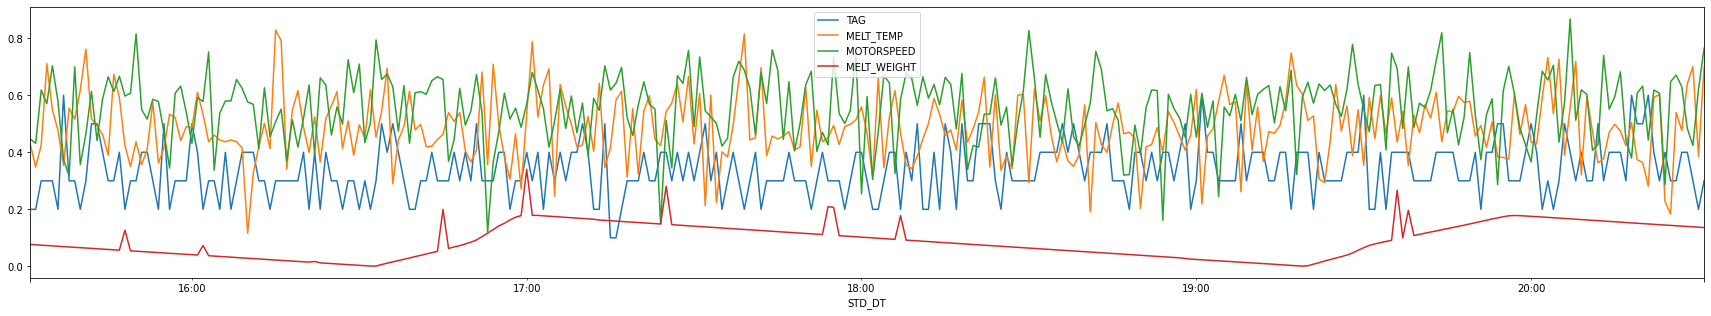

In [ ]:
data_ts_n.loc['2020-03-19 15:31:00' : '2020-03-19 20:31:00'][['TAG','MELT_TEMP','MOTORSPEED','MELT_WEIGHT']].plot(figsize=(30,5))
plt.show()

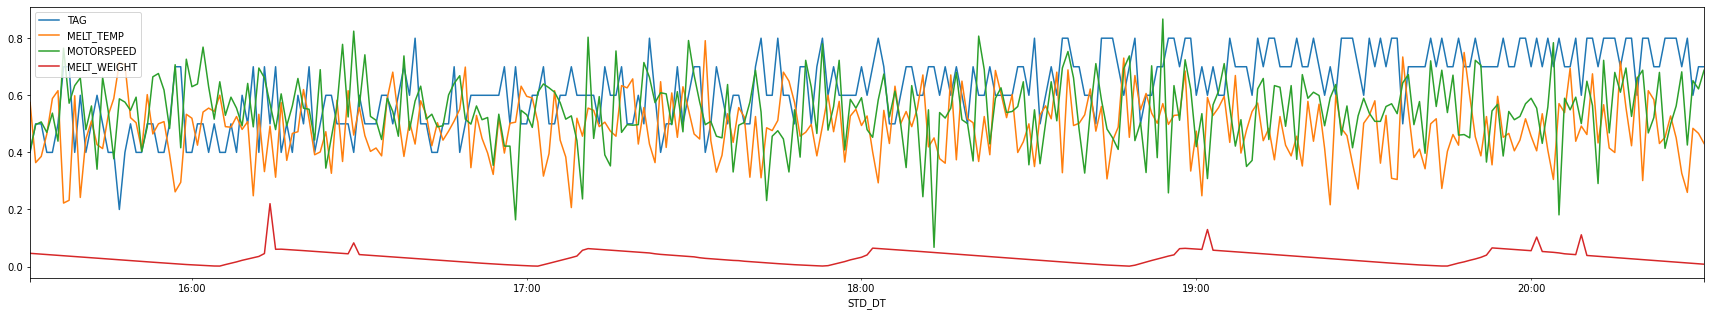

In [ ]:
data_ts_n.loc['2020-03-25 15:31:00' : '2020-03-25 20:31:00'][['TAG','MELT_TEMP','MOTORSPEED', 'MELT_WEIGHT']].plot(figsize=(30,5))
plt.show()

In [ ]:
rf = RandomForestClassifier()

In [ ]:
X_a = data_add.drop(columns=['NUM', 'TAG'])
X = data_p[['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']]
y = data_p['TAG']

In [ ]:
X_a = X_a.reset_index().drop(index=outlier)

In [ ]:
X_a = X_a.drop(columns='STD_DT')

In [ ]:
X_a.shape, y.shape

((835194, 11), (835194,))

In [ ]:
scores = cross_val_score(rf , X , y ,scoring ='f1', cv=3)

In [ ]:
# 랜덤포레스트 : CV(3) : 바로 적용하면 성능 매우 낮음
scores

array([0.31716112, 0.26208431, 0.28452541])

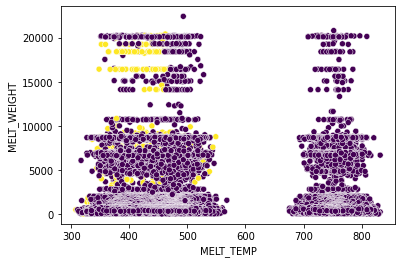

In [ ]:
# 왜 웨이트가 쓰이는지 궁금해서 시각화해봅니다.
# 좋은 인사이트인것 같습니다.

sns.scatterplot(data=data_p, x ='MELT_TEMP', y='MELT_WEIGHT', c=y)

In [ ]:
data_p['derived_W/T'] = data_p['MELT_WEIGHT'] / data_p['MELT_TEMP']

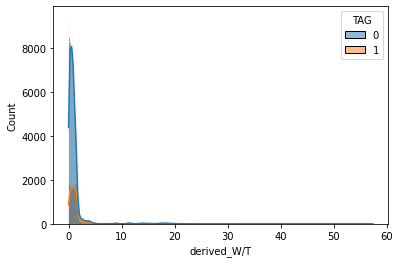

In [ ]:
sns.histplot(data= data_p, x='derived_W/T', hue = 'TAG', kde=True)
# sns.boxplot(data= data_p, y='derived_W/T', x='TAG', ax = axs[1])

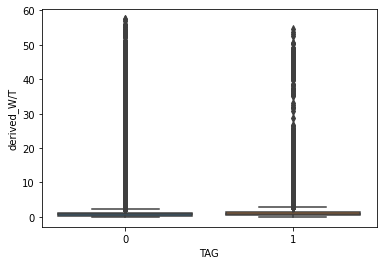

In [ ]:
sns.boxplot(data= data_p, y='derived_W/T', x='TAG')

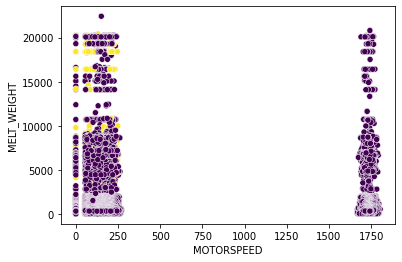

In [ ]:
sns.scatterplot(data=data_p, x ='MOTORSPEED', y='MELT_WEIGHT', c=y)

In [ ]:
X_log = np.log1p(X)
X_log

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP
0        6.194405    4.762174     6.448889  1.432701
1        6.073045    4.369448     6.413459  1.432701
2        6.142037    5.043425     6.411818  1.432701
3        5.940171    5.361292     6.408529  1.432701
4        6.683361    7.459915     6.405228  1.437463
...           ...         ...          ...       ...
835195   6.628041    7.463937     5.765191  1.437463
835196   5.955837    5.332719     5.762051  1.432701
835197   6.144186    5.003946     5.758902  1.435085
835198   6.148468    0.000000     5.752573  1.432701
835199   6.118097    4.836282     5.746203  1.435085

[835194 rows x 4 columns]

In [ ]:
y

0         0
1         0
2         0
3         0
4         0
         ..
835195    0
835196    0
835197    0
835198    0
835199    0
Name: TAG, Length: 835194, dtype: int64

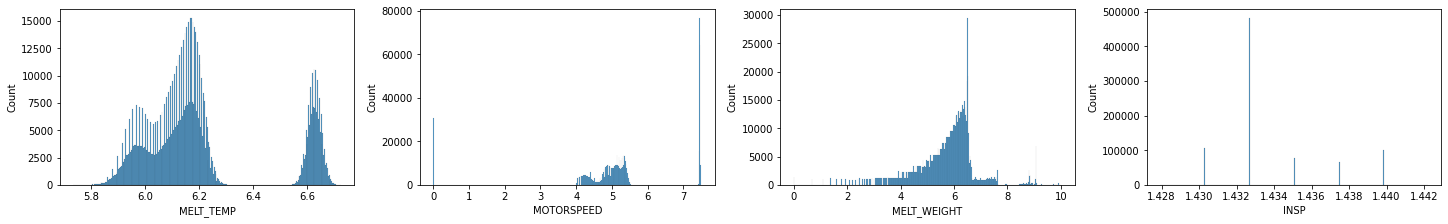

In [ ]:
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.histplot(data=X_log, x= col, ax = axs[idx])

In [ ]:
rf = RandomForestClassifier()
scores = cross_val_score(rf , X_log , y ,scoring ='f1', cv=3)

In [ ]:
scores

# log1p도 답이 아님

array([0.31643457, 0.2600422 , 0.2831519 ])

In [ ]:
# SMOTE 라이브러리
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=0)
X_over, y_over = smote.fit_resample(X, y)

In [ ]:
y_over.value_counts()

0    658129
1    658129
Name: TAG, dtype: int64

In [ ]:
rf = RandomForestClassifier()
scores = cross_val_score(rf , X_over , y_over ,scoring ='f1', cv=3)

In [ ]:
# baseline : smote 한 결과
scores.mean()

0.8158279401966327

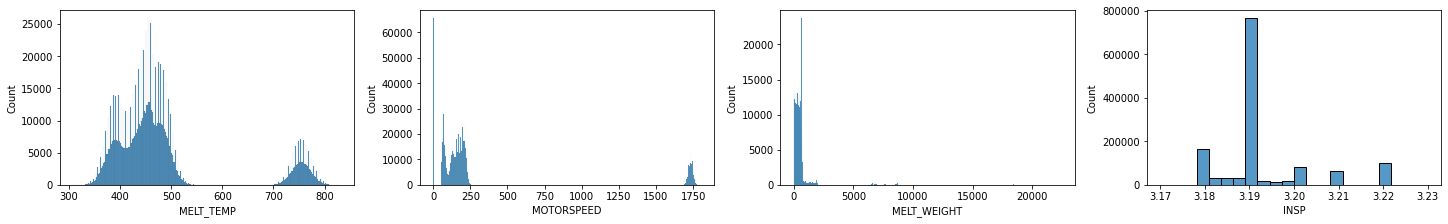

In [ ]:
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.histplot(data=X_over, x= col, ax = axs[idx])

In [ ]:
X_over_log = np.log1p(X_over)
X_over_log

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP
0         6.194405    4.762174     6.448889  1.432701
1         6.073045    4.369448     6.413459  1.432701
2         6.142037    5.043425     6.411818  1.432701
3         5.940171    5.361292     6.408529  1.432701
4         6.683361    7.459915     6.405228  1.437463
...            ...         ...          ...       ...
1316253   6.073045    4.077537     6.018593  1.432565
1316254   6.025866    4.624973     5.537334  1.432701
1316255   6.045005    4.248495     6.313548  1.434868
1316256   5.988961    5.351858     5.267858  1.430311
1316257   6.131226    4.158883     6.413459  1.434010

[1316258 rows x 4 columns]

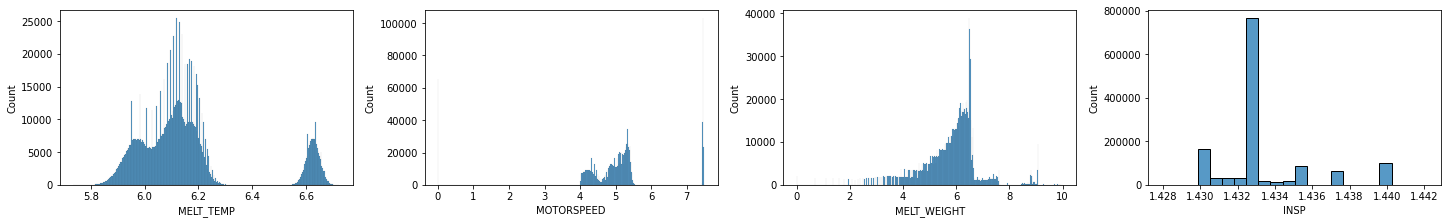

In [ ]:
li = ['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']

fig, axs = plt.subplots(figsize=(20,3), nrows=1, ncols=4, constrained_layout=True)

for idx, col in enumerate(li) :
    sns.histplot(data=X_over_log, x= col, ax = axs[idx])

In [ ]:
rf = RandomForestClassifier()
scores = cross_val_score(rf , X_over_log , y_over ,scoring ='f1', cv=3)

In [ ]:
scores.mean()

0.8153500641444887

In [ ]:
data_v = pd.concat([X_over_log, y_over], axis=1)

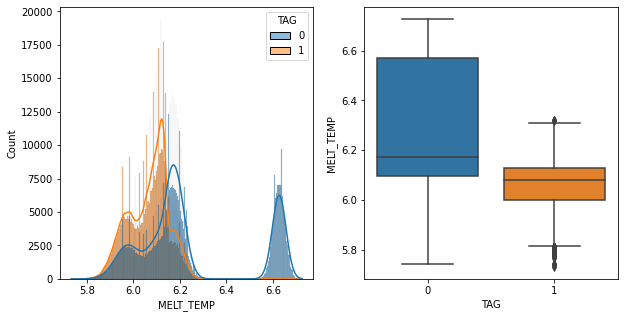

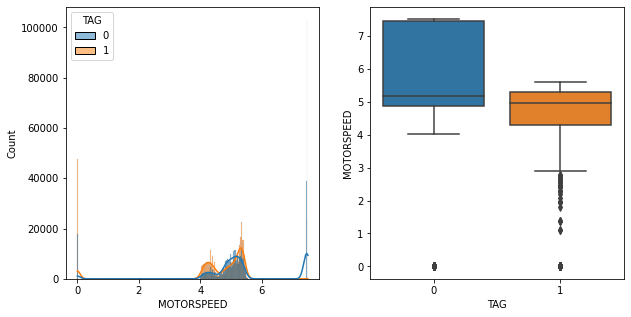

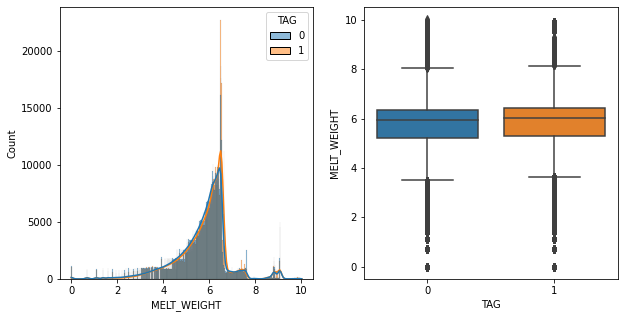

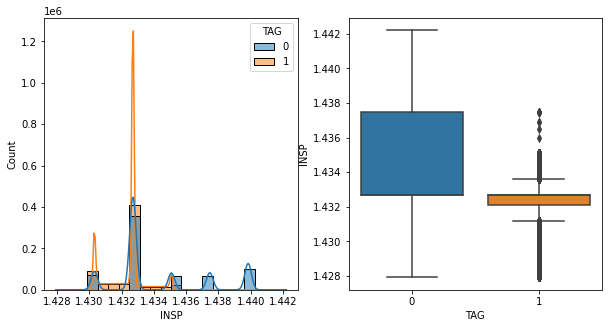

In [ ]:
# smote 데이터 확인
for i in li :

  fig, axs = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

  sns.histplot(data= data_v, x=i, hue = 'TAG', kde=True, ax = axs[0])
  sns.boxplot(data= data_v, y=i, x='TAG', ax = axs[1])

In [ ]:
rf.fit(X_over_log , y_over)

RandomForestClassifier()

In [ ]:
rf.feature_importances_

array([0.30709678, 0.18788135, 0.33738235, 0.16763952])

In [ ]:
X_over_log_no_w = X_over_log[['MELT_TEMP', 'MOTORSPEED', 'INSP']]
X_over_log_no_w

MELT_TEMP  MOTORSPEED      INSP
0         6.194405    4.762174  1.432701
1         6.073045    4.369448  1.432701
2         6.142037    5.043425  1.432701
3         5.940171    5.361292  1.432701
4         6.683361    7.459915  1.437463
...            ...         ...       ...
1316253   6.073045    4.077537  1.432565
1316254   6.025866    4.624973  1.432701
1316255   6.045005    4.248495  1.434868
1316256   5.988961    5.351858  1.430311
1316257   6.131226    4.158883  1.434010

[1316258 rows x 3 columns]

In [ ]:
y_over

0          0
1          0
2          0
3          0
4          0
          ..
1316253    1
1316254    1
1316255    1
1316256    1
1316257    1
Name: TAG, Length: 1316258, dtype: int64

In [ ]:
# no_w 아무리 생각해도 이상하다고
rf = RandomForestClassifier()
scores = cross_val_score(rf , X_over_log_no_w , y_over ,scoring ='f1', cv=3)

In [ ]:
scores.mean()

0.7594002595420583

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0, stratify=y)


In [ ]:
rf.fit()

In [ ]:
rf.fit(X_over_log , y)

RandomForestClassifier()

In [ ]:
pred = rf.predict(X_test)
pred

array(['NG', 'OK', 'OK', ..., 'OK', 'OK', 'OK'], dtype=object)

In [ ]:
confusion = confusion_matrix(y_test, pred)

In [ ]:
confusion

array([[ 10667,  24746],
       [ 13978, 117648]])

In [ ]:
accuracy_score(y_test , pred)

0.768173899508498

In [ ]:
(10667 + 117648) / y_test.shape[0]

0.768173899508498

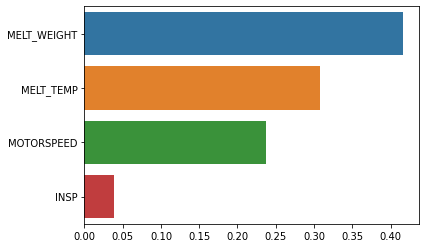

In [ ]:
feature_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
lgbmcf = LGBMClassifier()
scores = cross_val_score(lgbmcf , X , y , scoring='accuracy', cv=3)

In [ ]:
scores

array([0.69871049, 0.79720546, 0.71597701])

In [ ]:
lgbmcf.fit(X , y)

LGBMClassifier()

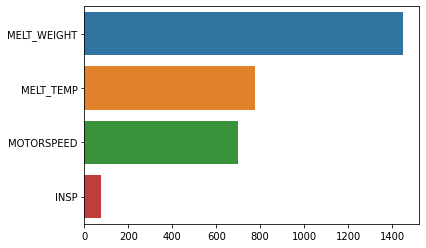

In [ ]:
feature_series = pd.Series(lgbmcf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

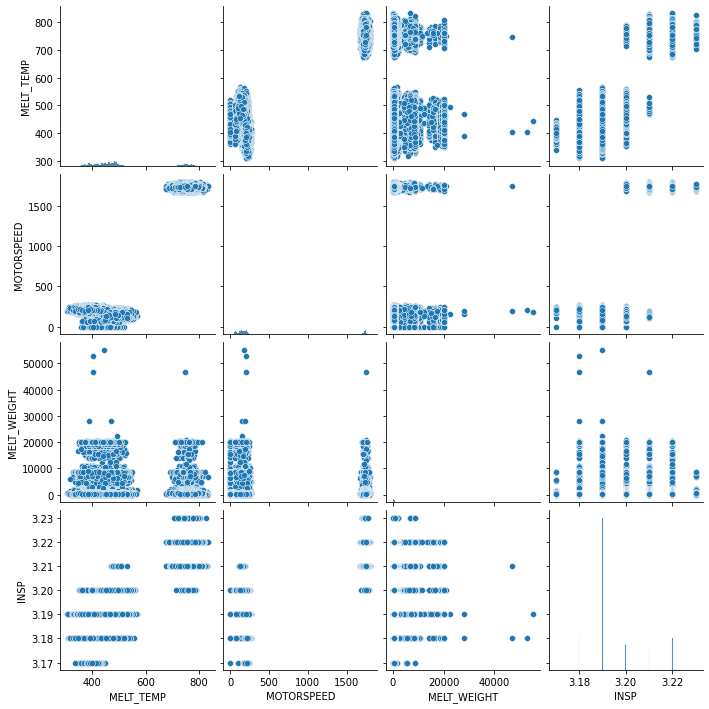

In [ ]:
sns.pairplot(data=X)

In [ ]:
X.corr()

MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP
MELT_TEMP     1.000000    0.944929    -0.000336  0.916295
MOTORSPEED    0.944929    1.000000     0.000123  0.887813
MELT_WEIGHT  -0.000336    0.000123     1.000000 -0.000005
INSP          0.916295    0.887813    -0.000005  1.000000

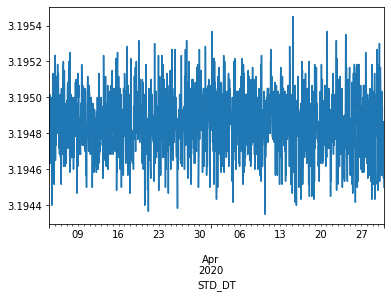

In [ ]:
data_ts.resample('H').mean()['INSP'].plot()

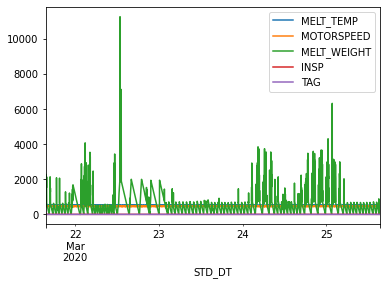

In [ ]:
data_ts.resample('T').mean().loc['2020-03-21 15:31:00' : '2020-03-25 15:31:00'][['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP','TAG']].plot()

In [ ]:
data_ts.resample('T').mean()[['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP','TAG']].iloc[].plot()

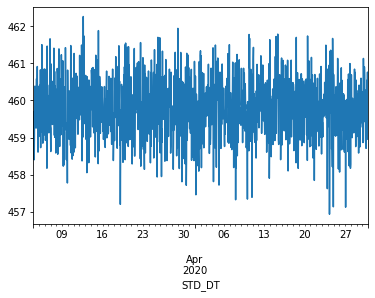

In [ ]:
data_ts.resample('H').mean()['MOTORSPEED'].plot()

In [ ]:
data_ts_n.resample('H').mean()['TAG'].plot(figsize=(50,10))
data_ts_n.resample('H').mean()['MOTORSPEED'].plot(figsize=(50,10))

In [ ]:
data_ts_n.resample('T').mean()['TAG'].iloc[30000:35000].plot(figsize=(50,10))
data_ts_n.resample('T').mean()['MELT_WEIGHT'].iloc[30000:35000].plot(figsize=(50,10))

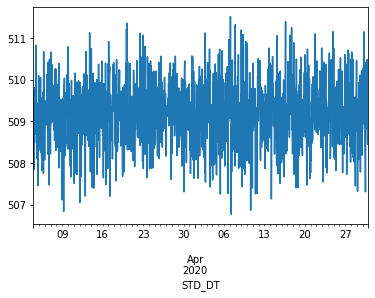

In [ ]:
data_ts.resample('H').mean()['MELT_TEMP'].plot()

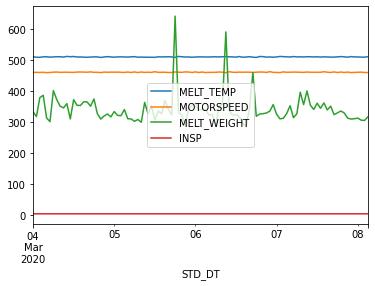

In [ ]:
data_ts.resample('H').mean()[['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP']].head(100).plot()

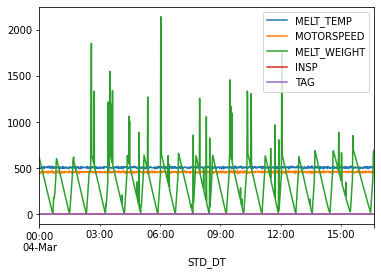

In [ ]:
data_ts.resample('T').mean()[['MELT_TEMP',	'MOTORSPEED',	'MELT_WEIGHT',	'INSP','TAG']].head(1000).plot()

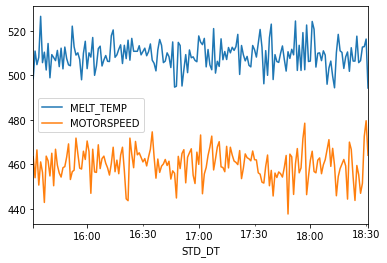

In [ ]:
data_ts.resample('T').mean()[['MELT_TEMP',	'MOTORSPEED']].loc['2020-03-21 15:31:00' : '2020-03-21 18:31:00'].plot()

In [ ]:
data_ts

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP  TAG
STD_DT                                                                    
2020-03-04 00:00:00       0        489         116          631  3.19    0
2020-03-04 00:00:00       1        433          78          609  3.19    0
2020-03-04 00:00:00       2        464         154          608  3.19    0
2020-03-04 00:00:00       3        379         212          606  3.19    0
2020-03-04 00:00:00       4        798        1736          604  3.21    0
...                     ...        ...         ...          ...   ...  ...
2020-04-30 23:59:00  835195        755        1743          318  3.21    0
2020-04-30 23:59:00  835196        385         206          317  3.19    0
2020-04-30 23:59:00  835197        465         148          316  3.20    0
2020-04-30 23:59:00  835198        467           0          314  3.19    0
2020-04-30 23:59:00  835199        453         125          312  3.20    0

[835200 rows x 6 columns]

In [ ]:
data_ts.resample('T').mean()[data_ts.resample('T').mean()['TAG'] > 0.75]

NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT   INSP  TAG
STD_DT                                                                       
2020-03-21 15:31:00  254114.5      498.5       463.4       1517.9  3.194  0.8
2020-03-22 08:39:00  264394.5      492.0       456.0        498.6  3.195  0.8
2020-03-22 22:41:00  272814.5      500.1       458.3       1114.2  3.195  0.8
2020-03-24 03:05:00  289854.5      493.4       456.8        477.7  3.196  0.8
2020-03-24 19:35:00  299754.5      501.6       459.5         45.5  3.193  0.8
...                       ...        ...         ...          ...    ...  ...
2020-04-05 04:03:00  463234.5      495.6       452.8        315.6  3.196  0.8
2020-04-05 14:25:00  469454.5      502.5       468.5        318.3  3.196  0.8
2020-04-05 14:31:00  469514.5      492.9       464.5        224.8  3.195  0.8
2020-04-05 15:24:00  470044.5      504.1       457.2        180.9  3.193  0.8
2020-04-05 17:36:00  471364.5      501.5       466.0        519.9  3.194  0.8

[7829 rows x 6 columns]

### 데이터 증강 후

In [ ]:
# SMOTE 라이브러리
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=0)
X_a_over, y_over = smote.fit_resample(X_a, y)

In [ ]:
X_a_over.shape

(1316258, 11)

In [ ]:
y_over.shape

(1316258,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_a_over, y_over,
                                                    test_size=0.2, random_state=0, stratify=y_over)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

RandomForestClassifier()

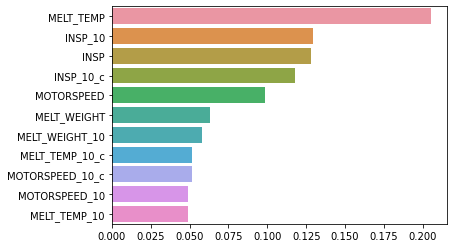

In [ ]:
feature_series = pd.Series(rf.feature_importances_, index=X_a_over.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

# f1 : 8628

0.8708006017048303 0.919390595999175 0.8128713172169633 0.8628559447101234
